# Clustering NYC Geographic Data
## CS 463/663 — Machine Learning
### Spring 2025

In this notebook, we will explore clustering algorithms applied to New York City geographic data. We'll analyze two distinct spatial datasets that demonstrate the different strengths of K-Means and DBSCAN clustering:

1. NYC Public Schools
2. NYC Public Art

Through this analysis, you will demonstrate how different clustering approaches can be applied to varying types of geospatial data.

In [16]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as SklearnKMeans, DBSCAN
from sklearn.metrics import silhouette_score
import json # used to read in NYC public art dataset
import seaborn as sns
import re

# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/My Drive/CS463"

np.random.seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1: Implementation of k-Means


In [17]:
class KMeans:
    def __init__(self, n_clusters=3, max_iters=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def fit(self, X):
        # Set random seed if provided
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Get dimensions of the data
        n_samples, n_features = X.shape

        # Initialize centroids randomly from data points
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices, :]

        # Initialize previous centroids to None for first iteration
        prev_centroids = None

        # Iterate until convergence or max_iters
        for _ in range(self.max_iters):
            # Calculate distances to centroids for all points
            distances = self._calculate_distances(X)

            # Assign each point to the nearest centroid
            self.labels_ = np.argmin(distances, axis=1)

            # Store the previous centroids for convergence check
            prev_centroids = self.centroids.copy()

            # Update centroids based on the mean of points in each cluster
            self._update_centroids(X)

            # Check for convergence
            if np.all(prev_centroids == self.centroids):
                break

        # Calculate inertia (sum of squared distances to the nearest centroid)
        self.inertia_ = self._calculate_inertia(X)

        return self

    def _calculate_distances(self, X):
        n_samples = X.shape[0]
        distances = np.zeros((n_samples, self.n_clusters))

        for i, centroid in enumerate(self.centroids):
            # Calculate Euclidean distance
            distances[:, i] = np.sqrt(np.sum((X - centroid) ** 2, axis=1))

        return distances

    def _update_centroids(self, X):
        for i in range(self.n_clusters):
            # Find all points assigned to this cluster
            cluster_points = X[self.labels_ == i]

            # If the cluster is not empty, update its centroid
            if len(cluster_points) > 0:
                self.centroids[i] = np.mean(cluster_points, axis=0)

    def _calculate_inertia(self, X):
        distances = self._calculate_distances(X)
        min_distances = distances[np.arange(X.shape[0]), self.labels_]
        return np.sum(min_distances ** 2)

    def predict(self, X):
        distances = self._calculate_distances(X)
        return np.argmin(distances, axis=1)

Number of schools with missing coordinates: 1
Dataset shape after removing missing coordinates: (2189, 41)


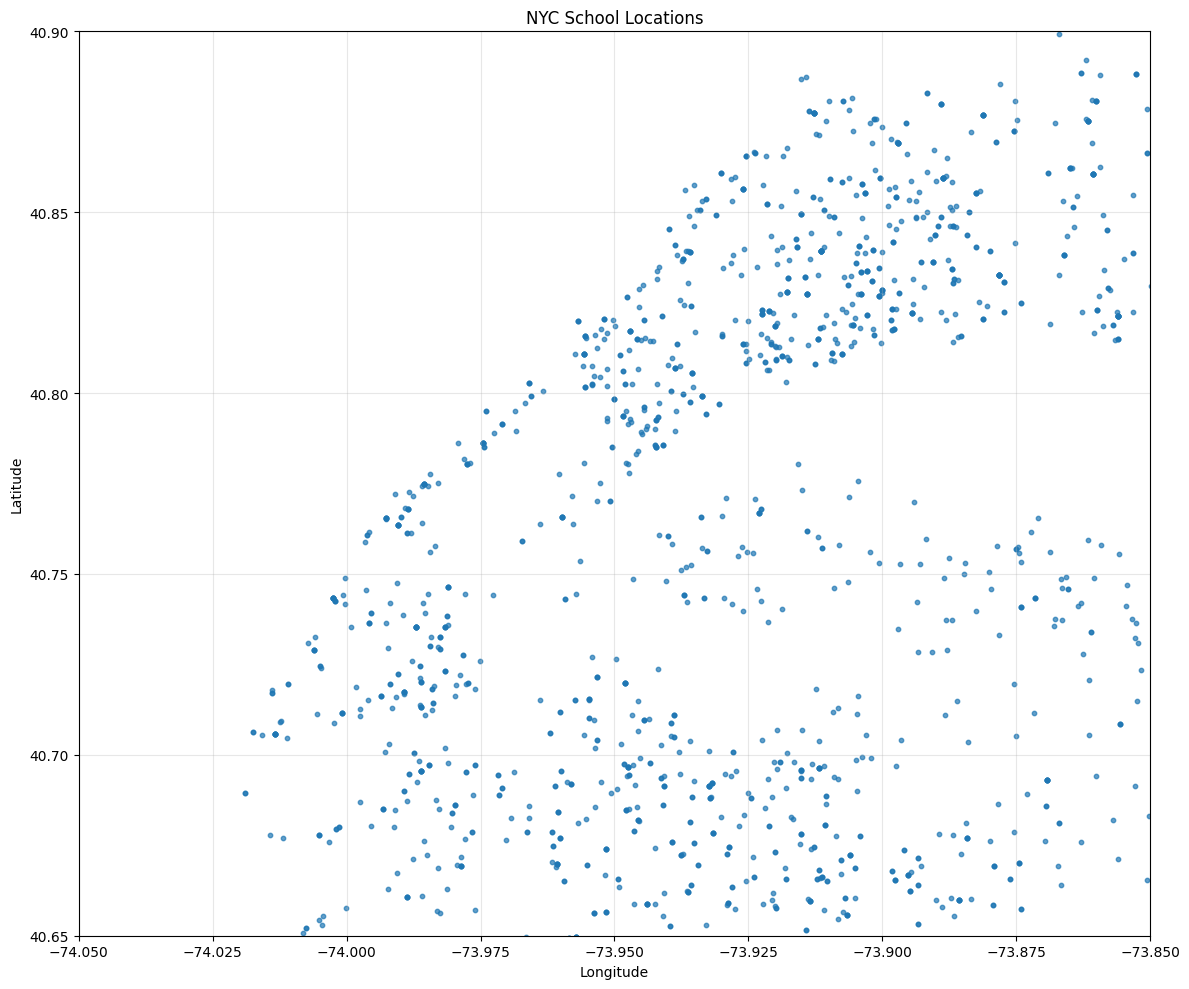

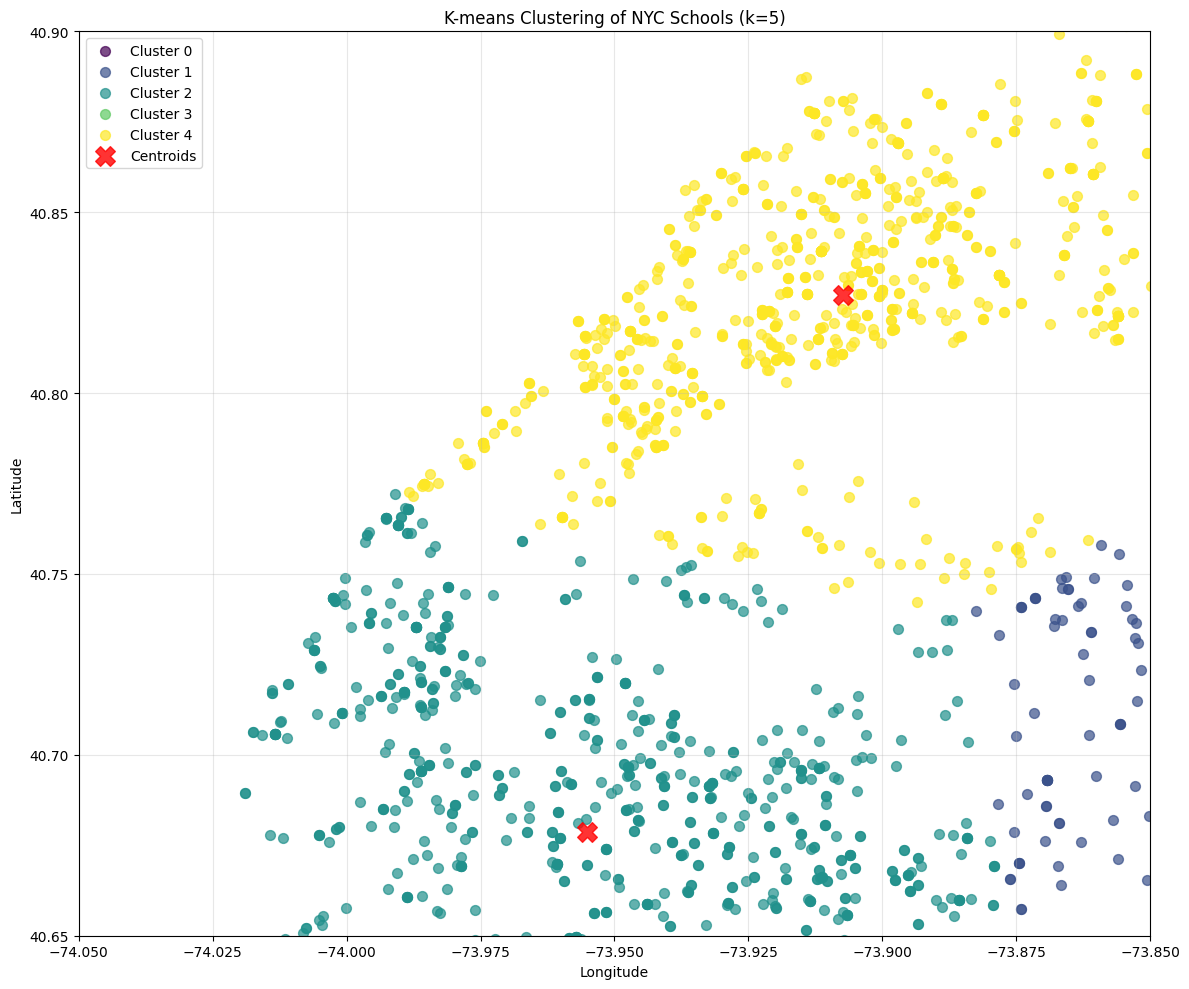

Silhouette Score: 0.5155
Inertia: 6.68


In [18]:
# Load the NYC schools data
DATA_PATH = "/content/drive/My Drive/CS463/"
df_schools = pd.read_csv(DATA_PATH + '2019_-_2020_School_Locations.csv')

# Check for missing coordinates and remove rows with missing values
missing_coords = df_schools[['LONGITUDE', 'LATITUDE']].isna().any(axis=1)
print(f"Number of schools with missing coordinates: {missing_coords.sum()}")

# Remove records with missing coordinates
df_clean = df_schools[~missing_coords].copy()
print(f"Dataset shape after removing missing coordinates: {df_clean.shape}")

# Extract features for clustering (coordinates)
X_schools = df_clean[['LONGITUDE', 'LATITUDE']].values

# Visualize the school locations on a map
plt.figure(figsize=(12, 10))
plt.scatter(X_schools[:, 0], X_schools[:, 1], s=10, alpha=0.7)
plt.title('NYC School Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# Set axis limits for NYC area
plt.xlim(-74.05, -73.85)
plt.ylim(40.65, 40.9)

plt.tight_layout()
plt.show()

# Applying K-means implementation
k = 5  # Try with 5 clusters
kmeans_model = KMeans(n_clusters=k, random_state=42)
kmeans_model.fit(X_schools)

# Visualize the clustering results
plt.figure(figsize=(12, 10))

# Create a colormap for clusters
colors = plt.cm.viridis(np.linspace(0, 1, k))

# Plot each cluster with a different color
for i, color in zip(range(k), colors):
    cluster_points = X_schools[kmeans_model.labels_ == i]
    plt.scatter(
        cluster_points[:, 0], cluster_points[:, 1],
        s=50, c=[color], label=f'Cluster {i}',
        alpha=0.7
    )

# Plot centroids
plt.scatter(
    kmeans_model.centroids[:, 0], kmeans_model.centroids[:, 1],
    s=200, c='red', marker='X', label='Centroids',
    alpha=0.8
)

plt.title('K-means Clustering of NYC Schools (k=5)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)

# Set axis limits for NYC area
plt.xlim(-74.05, -73.85)
plt.ylim(40.65, 40.9)

plt.tight_layout()
plt.show()

# Calculate silhouette score
silhouette = silhouette_score(X_schools, kmeans_model.labels_)
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Inertia: {kmeans_model.inertia_:.2f}")

## Part 2: Performance Analysis of k-Means

Evaluating with k=2...
  Inertia: 28.58
  Silhouette Score: 0.9983
Evaluating with k=3...
  Inertia: 15.55
  Silhouette Score: 0.4408
Evaluating with k=4...
  Inertia: 9.65
  Silhouette Score: 0.4910
Evaluating with k=5...
  Inertia: 6.68
  Silhouette Score: 0.5155
Evaluating with k=6...
  Inertia: 5.17
  Silhouette Score: 0.4493
Evaluating with k=7...
  Inertia: 4.41
  Silhouette Score: 0.3887
Evaluating with k=8...
  Inertia: 4.06
  Silhouette Score: 0.3474
Evaluating with k=9...
  Inertia: 3.46
  Silhouette Score: 0.3432
Evaluating with k=10...
  Inertia: 2.72
  Silhouette Score: 0.3940


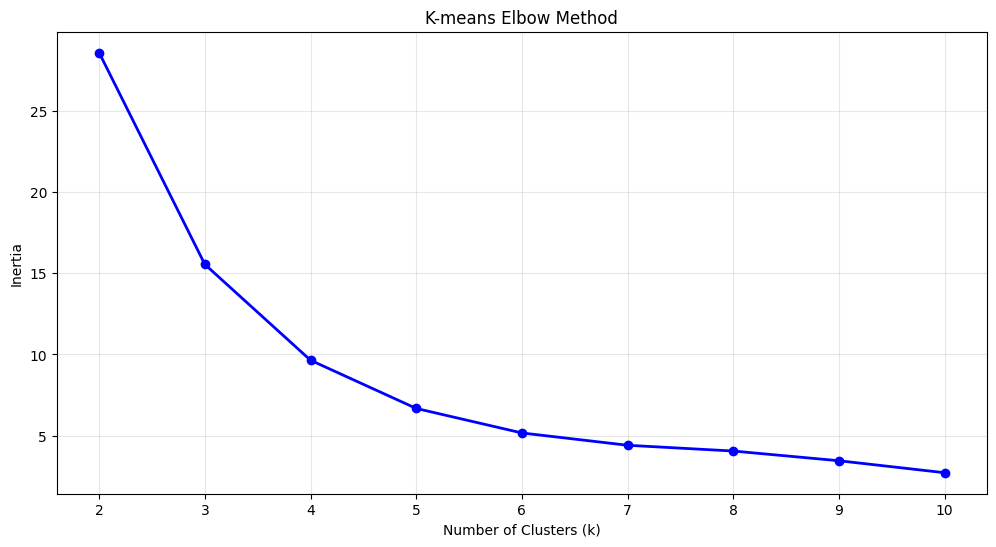

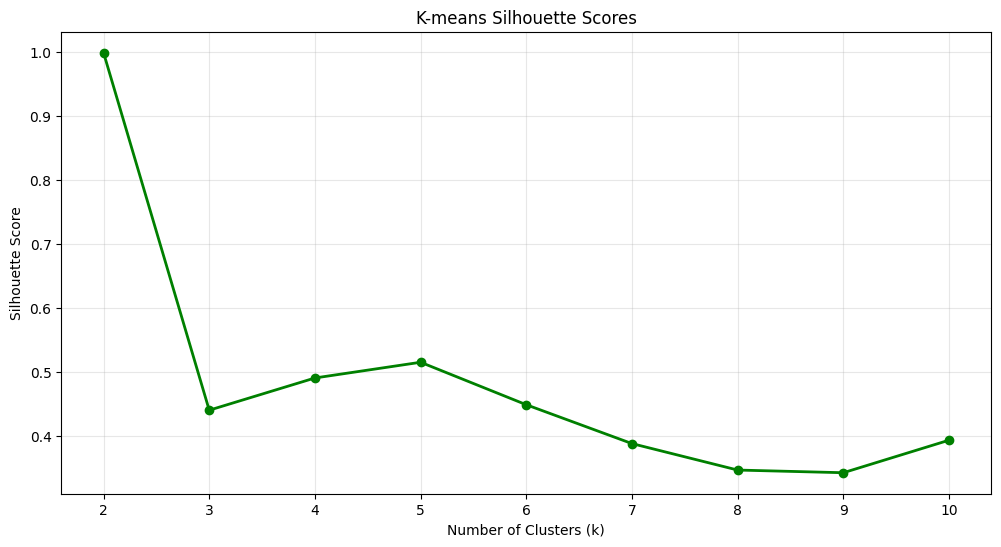

In [19]:
def evaluate_kmeans(X, max_clusters=10):
    inertias = []
    silhouette_scores = []

    # Evaluate with k from 2 to max_clusters
    for k in range(2, max_clusters + 1):
        print(f"Evaluating with k={k}...")

        # Using my custom implementation
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(X)

        # Store inertia
        inertias.append(model.inertia_)

        # Calculate silhouette score
        silhouette = silhouette_score(X, model.labels_)
        silhouette_scores.append(silhouette)
        print(f"  Inertia: {model.inertia_:.2f}")
        print(f"  Silhouette Score: {silhouette:.4f}")

    # Plot the elbow method
    plt.figure(figsize=(12, 6))
    plt.plot(range(2, max_clusters + 1), inertias, 'o-', color='blue', linewidth=2)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('K-means Elbow Method')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Plot silhouette scores
    plt.figure(figsize=(12, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, 'o-', color='green', linewidth=2)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('K-means Silhouette Scores')
    plt.grid(True, alpha=0.3)
    plt.show()

    return inertias, silhouette_scores

# Run the evaluation
inertias, silhouette_scores = evaluate_kmeans(X_schools, max_clusters=10)

In [20]:
def compare_implementations(X, k=5):
    import time

    print(f"Comparing implementations with k={k}...")

    # Time execution for custom implementation
    start_time = time.time()
    custom_model = KMeans(n_clusters=k, random_state=42)
    custom_model.fit(X)
    custom_time = time.time() - start_time

    # Time execution for sklearn implementation
    start_time = time.time()
    sklearn_model = SklearnKMeans(n_clusters=k, random_state=42)
    sklearn_model.fit(X)
    sklearn_time = time.time() - start_time

    # Compare results
    print("\nPerformance Comparison:")
    print(f"  Custom implementation time: {custom_time:.4f} seconds")
    print(f"  Sklearn implementation time: {sklearn_time:.4f} seconds")
    print(f"  Time ratio (custom/sklearn): {custom_time/sklearn_time:.4f}")
    print("\nQuality Comparison:")
    print(f"  Custom implementation inertia: {custom_model.inertia_:.2f}")
    print(f"  Sklearn implementation inertia: {sklearn_model.inertia_:.2f}")

    # Calculate silhouette score for both implementations
    custom_silhouette = silhouette_score(X, custom_model.labels_)
    sklearn_silhouette = silhouette_score(X, sklearn_model.labels_)

    print(f"  Custom implementation silhouette score: {custom_silhouette:.4f}")
    print(f"  Sklearn implementation silhouette score: {sklearn_silhouette:.4f}")

# Run the comparison
compare_implementations(X_schools, k=5)

Comparing implementations with k=5...

Performance Comparison:
  Custom implementation time: 0.0247 seconds
  Sklearn implementation time: 0.0038 seconds
  Time ratio (custom/sklearn): 6.4942

Quality Comparison:
  Custom implementation inertia: 6.68
  Sklearn implementation inertia: 8.07
  Custom implementation silhouette score: 0.5155
  Sklearn implementation silhouette score: 0.4282


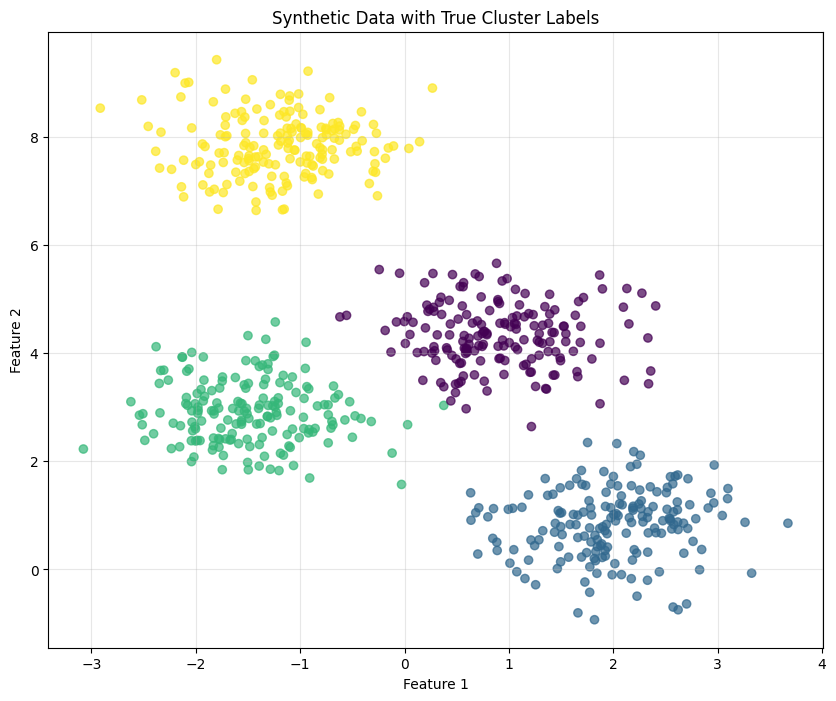

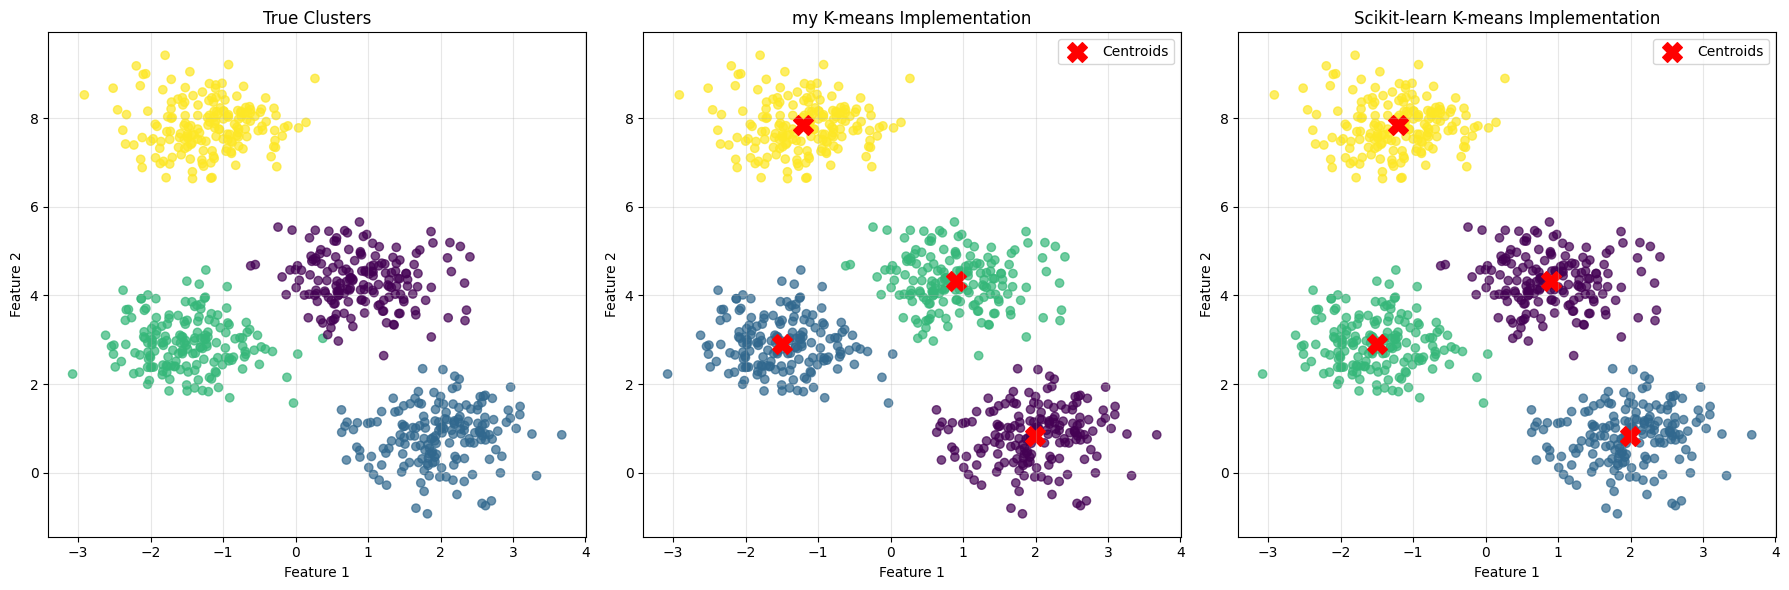

Comparison with True Clusters:
  My Implementation - Adjusted Rand Index: 0.9962, NMI: 0.9936
  Scikit-learn - Adjusted Rand Index: 0.9962, NMI: 0.9936

Inertia Comparison:
  My Implementation: 473.8318
  Scikit-learn: 473.8318
  Ratio (My/Sklearn): 1.0000

Comparison between Implementations:
  Adjusted Rand Index: 1.0000
  Normalized Mutual Information: 1.0000


In [22]:
# Part 2: Performance Analysis using Synthetic Data
from sklearn.datasets import make_blobs

# Generate synthetic data
X_synthetic, true_labels = make_blobs(
    n_samples=700,
    centers=4,
    cluster_std=0.60,
    random_state=0
)

# Visualize the synthetic data with true labels
plt.figure(figsize=(10, 8))
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], c=true_labels, cmap='viridis', alpha=0.7)
plt.title('Synthetic Data with True Cluster Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)
plt.show()

# Applying my k-means implementation
k = 4  # Same as the number of centers in make_blobs
my_kmeans = KMeans(n_clusters=k, random_state=42)
my_kmeans.fit(X_synthetic)
my_labels = my_kmeans.labels_

# Apply scikit-learn's k-means implementation
sklearn_kmeans = SklearnKMeans(n_clusters=k, random_state=42)
sklearn_kmeans.fit(X_synthetic)
sklearn_labels = sklearn_kmeans.labels_

# Visualize the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# True clusters
axs[0].scatter(X_synthetic[:, 0], X_synthetic[:, 1], c=true_labels, cmap='viridis', alpha=0.7)
axs[0].set_title('True Clusters')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
axs[0].grid(True, alpha=0.3)

# my implementation
axs[1].scatter(X_synthetic[:, 0], X_synthetic[:, 1], c=my_labels, cmap='viridis', alpha=0.7)
axs[1].scatter(my_kmeans.centroids[:, 0], my_kmeans.centroids[:, 1],
               c='red', marker='X', s=200, label='Centroids')
axs[1].set_title('my K-means Implementation')
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('Feature 2')
axs[1].grid(True, alpha=0.3)
axs[1].legend()

# Scikit-learn's implementation
axs[2].scatter(X_synthetic[:, 0], X_synthetic[:, 1], c=sklearn_labels, cmap='viridis', alpha=0.7)
axs[2].scatter(sklearn_kmeans.cluster_centers_[:, 0], sklearn_kmeans.cluster_centers_[:, 1],
               c='red', marker='X', s=200, label='Centroids')
axs[2].set_title('Scikit-learn K-means Implementation')
axs[2].set_xlabel('Feature 1')
axs[2].set_ylabel('Feature 2')
axs[2].grid(True, alpha=0.3)
axs[2].legend()

plt.tight_layout()
plt.show()

# Calculate evaluation metrics for each implementation
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Compare to true labels
ari_my = adjusted_rand_score(true_labels, my_labels)
ari_sklearn = adjusted_rand_score(true_labels, sklearn_labels)

nmi_my = normalized_mutual_info_score(true_labels, my_labels)
nmi_sklearn = normalized_mutual_info_score(true_labels, sklearn_labels)

# Compare inertias
my_inertia = my_kmeans.inertia_
sklearn_inertia = sklearn_kmeans.inertia_

# Compare my implementation vs sklearn
ari_comparison = adjusted_rand_score(my_labels, sklearn_labels)
nmi_comparison = normalized_mutual_info_score(my_labels, sklearn_labels)

# Print results
print("Comparison with True Clusters:")
print(f"  My Implementation - Adjusted Rand Index: {ari_my:.4f}, NMI: {nmi_my:.4f}")
print(f"  Scikit-learn - Adjusted Rand Index: {ari_sklearn:.4f}, NMI: {nmi_sklearn:.4f}")
print("\nInertia Comparison:")
print(f"  My Implementation: {my_inertia:.4f}")
print(f"  Scikit-learn: {sklearn_inertia:.4f}")
print(f"  Ratio (My/Sklearn): {my_inertia/sklearn_inertia:.4f}")
print("\nComparison between Implementations:")
print(f"  Adjusted Rand Index: {ari_comparison:.4f}")
print(f"  Normalized Mutual Information: {nmi_comparison:.4f}")

## Part 3: Dataset Clustering Analysis

Successfully loaded JSON data with 1173 entries

=== BASIC DATASET INFORMATION ===
Number of records: 1173
Number of columns: 10

Columns in the dataset:
  - name
  - artist
  - from_date
  - to_date
  - location
  - description
  - borough
  - lat
  - lng
  - active

=== DATA TYPES ===
  name: str (Example: A View from the Lunch Table: Students Bringing Iss...)
  artist: str (Example: LEAP)
  from_date: str (Example: 2009-05-28)
  to_date: str (Example: 2009-09-30)
  location: str (Example: Various Locations)
  description: str (Example: <span style="font-family: Verdana; font-size: 11px...)
  borough: str (Example: c)
  lat: str (Example: 40.76543)
  lng: str (Example: -73.97264)
  active: str (Example: 1)

=== MISSING VALUES ===
  name: 0 missing values (0.0%)
  artist: 25 missing values (2.1%)
  from_date: 0 missing values (0.0%)
  to_date: 0 missing values (0.0%)
  location: 793 missing values (67.6%)
  description: 1 missing values (0.1%)
  borough: 0 missing values (0.0%)
  lat:

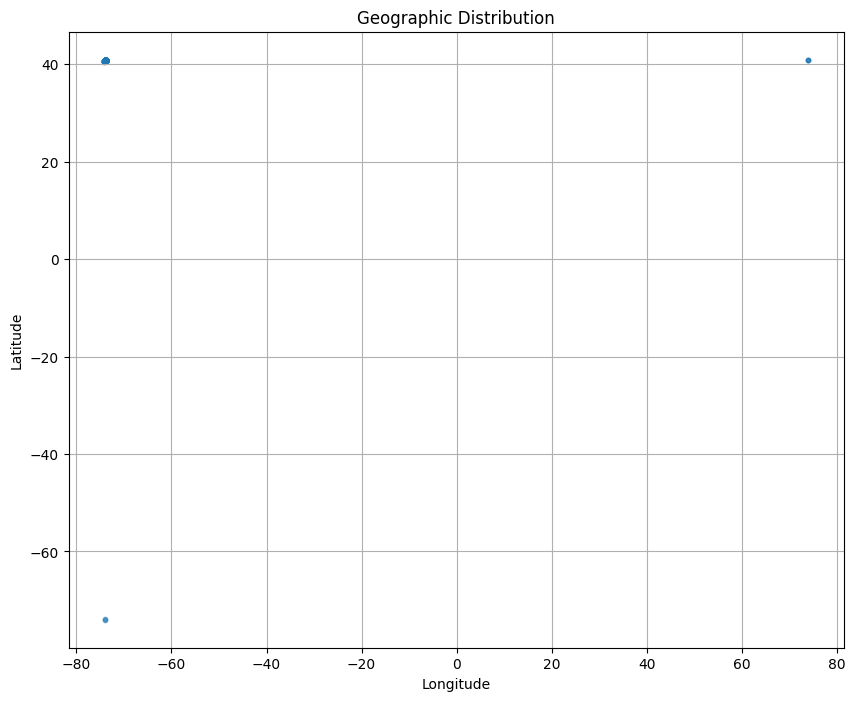


Valid coordinate pairs: 880 (75.0% of data)

=== CATEGORICAL VALUES ===
  borough - 6 unique values:
    M: 669 records (57.0%)
    B: 186 records (15.9%)
    Q: 182 records (15.5%)
    X: 62 records (5.3%)
    c: 40 records (3.4%)
    ... 1 more values
  active - 2 unique values:
    1: 1172 records (99.9%)
    0: 1 records (0.1%)

=== SAMPLE RECORD ===
{
  "name": "A View from the Lunch Table: Students Bringing Issues to the Table",
  "artist": "LEAP",
  "from_date": "2009-05-28",
  "to_date": "2009-09-30",
  "location": "Various Locations",
  "description": "<span style=\"font-family: Verdana; font-size: 11px; color: rgb(68, 68, 68); line-height: 15px;\"><p style=\"margin: 0px 0px 1em; padding: 0px;\">Students from ten New York City public middle schools, with two schools representing each borough, have transformed lunch school tables into personalized canvases and created colorful works of public art that touch upon critical social issues in their community and across the globe. T

In [28]:
# Exploring and trying to visualize JSON Dataset Structure with the help of AI
def explore_json_dataset(file_path):
    """
    Thoroughly examine and explain a JSON dataset structure.

    Parameters:
    -----------
    file_path : str
        Path to the JSON file.
    """
    try:
        # Load the JSON file
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

        print(f"Successfully loaded JSON data with {len(data)} entries")

        # Convert to DataFrame for easier analysis
        df = pd.DataFrame(data)

        # 1. Basic Dataset Information
        print("\n=== BASIC DATASET INFORMATION ===")
        print(f"Number of records: {len(df)}")
        print(f"Number of columns: {len(df.columns)}")
        print("\nColumns in the dataset:")
        for col in df.columns:
            print(f"  - {col}")

        # 2. Data Types
        print("\n=== DATA TYPES ===")
        for col in df.columns:
            # Get unique values to determine actual data type
            unique_values = df[col].dropna().unique()
            if len(unique_values) > 0:
                example_value = unique_values[0]
                print(f"  {col}: {type(example_value).__name__} (Example: {str(example_value)[:50]}{'...' if len(str(example_value)) > 50 else ''})")
            else:
                print(f"  {col}: No non-null values")

        # 3. Missing Values
        print("\n=== MISSING VALUES ===")
        for col in df.columns:
            missing = df[col].isna().sum()
            missing_percent = (missing / len(df)) * 100
            print(f"  {col}: {missing} missing values ({missing_percent:.1f}%)")

        # 4. Coordinate Information (if available)
        coord_columns = [col for col in df.columns if col.lower() in ['lat', 'latitude', 'lng', 'longitude']]

        if coord_columns:
            print("\n=== COORDINATE INFORMATION ===")
            for col in coord_columns:
                # Convert to numeric in case it's stored as string
                df[col] = pd.to_numeric(df[col], errors='coerce')

                non_null = df[col].dropna()
                if len(non_null) > 0:
                    print(f"  {col}:")
                    print(f"    Range: {non_null.min()} to {non_null.max()}")
                    print(f"    Mean: {non_null.mean()}")
                    print(f"    Median: {non_null.median()}")
                else:
                    print(f"  {col}: All values are null")

            # Plot coordinates (if both lat and lng exist)
            if 'lat' in df.columns and 'lng' in df.columns:
                valid_coords = df.dropna(subset=['lat', 'lng'])
                if len(valid_coords) > 0:
                    plt.figure(figsize=(10, 8))
                    plt.scatter(valid_coords['lng'], valid_coords['lat'], alpha=0.5, s=10)
                    plt.title("Geographic Distribution")
                    plt.xlabel("Longitude")
                    plt.ylabel("Latitude")
                    plt.grid(True)
                    plt.show()

                    print(f"\nValid coordinate pairs: {len(valid_coords)} ({len(valid_coords)/len(df)*100:.1f}% of data)")

        # 5. Categorical Columns
        categorical_columns = [col for col in df.columns if df[col].nunique() < 20 and col not in coord_columns]

        if categorical_columns:
            print("\n=== CATEGORICAL VALUES ===")
            for col in categorical_columns:
                value_counts = df[col].value_counts()
                print(f"  {col} - {len(value_counts)} unique values:")
                for val, count in value_counts.head(5).items():
                    print(f"    {val}: {count} records ({count/len(df)*100:.1f}%)")
                if len(value_counts) > 5:
                    print(f"    ... {len(value_counts)-5} more values")

        # 6. Sample Record
        print("\n=== SAMPLE RECORD ===")
        print(json.dumps(data[0], indent=2))

        return df

    except Exception as e:
        print(f"Error exploring dataset: {e}")
        return None

# Call the function with your JSON file path
art_data_df = explore_json_dataset(DATA_PATH + '/DPR_PublicArt_001.json')

In [23]:
# Load and process NYC Public Art data from the JSON file
def load_public_art_data(file_path):
    """
    Load NYC Public Art data from JSON file.

    Parameters:
    -----------
    file_path : str
        Path to the JSON file containing art installation data.

    Returns:
    --------
    df : DataFrame
        DataFrame containing the processed art data.
    """
    try:
        # Read the JSON file
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

        print(f"Successfully loaded JSON data with {len(data)} entries")

        # Convert to DataFrame
        df = pd.DataFrame(data)

        # Check what coordinate columns are available
        print("Columns in the dataset:", df.columns.tolist())

        # Look for coordinate columns (they might have different names)
        coord_columns = [col for col in df.columns if 'lat' in col.lower() or 'lon' in col.lower()]
        print(f"Found coordinate columns: {coord_columns}")

        # If no standard coordinate columns found, look at the first few rows
        if not coord_columns:
            print("\nSample data from the first entry:")
            print(json.dumps(data[0], indent=2))

        return df

    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

# Load the art data from the JSON file
art_file_path = DATA_PATH + '/DPR_PublicArt_001.json'
print("Loading NYC Public Art data...")
df_art = load_public_art_data(art_file_path)

# Display basic information
print("\nArt data shape:", df_art.shape)
print("\nFirst few rows:")
display(df_art.head())

Loading NYC Public Art data...
Successfully loaded JSON data with 1173 entries
Columns in the dataset: ['name', 'artist', 'from_date', 'to_date', 'location', 'description', 'borough', 'lat', 'lng', 'active']
Found coordinate columns: ['lat']

Art data shape: (1173, 10)

First few rows:


,name,artist,from_date,to_date,location,description,borough,lat,lng,active
0,A View from the Lunch Table: Students Bringing...,LEAP,2009-05-28,2009-09-30,Various Locations,"<span style=""font-family: Verdana; font-size: ...",c,None,None,1
1,Tree Museum,Katie Holten,2009-06-21,2010-02-15,Grand Concourse,"&#8203;<span style=""font-family: Verdana; font...",X,None,None,1
2,The Ego and the Id,Franz West,2009-07-01,2010-07-16,Doris Freedman Plaza,<p><em>The Ego and the Id</em> is internationa...,M,None,None,1
3,The River that Flows Both Ways,Spencer Finch,2009-06-01,2010-06-30,None,"<font size=""3"" color=""#444444"" face=""Verdana"">...",M,None,None,1
4,A Clearing in the Streets,Julie Farris and Sarah Wayland-Smith,2009-05-22,2009-10-01,None,"<span style=""font-family: Verdana; font-size: ...",M,None,None,1


Checking coordinates...
Number of art installations with missing coordinates: 293
Percentage of data with missing coordinates: 25.0%
Data shape after removing missing coordinates: (880, 10)

Borough distribution:
  M: 488 installations (55.5%)
  Q: 154 installations (17.5%)
  B: 150 installations (17.0%)
  X: 52 installations (5.9%)
  R: 31 installations (3.5%)
  c: 5 installations (0.6%)


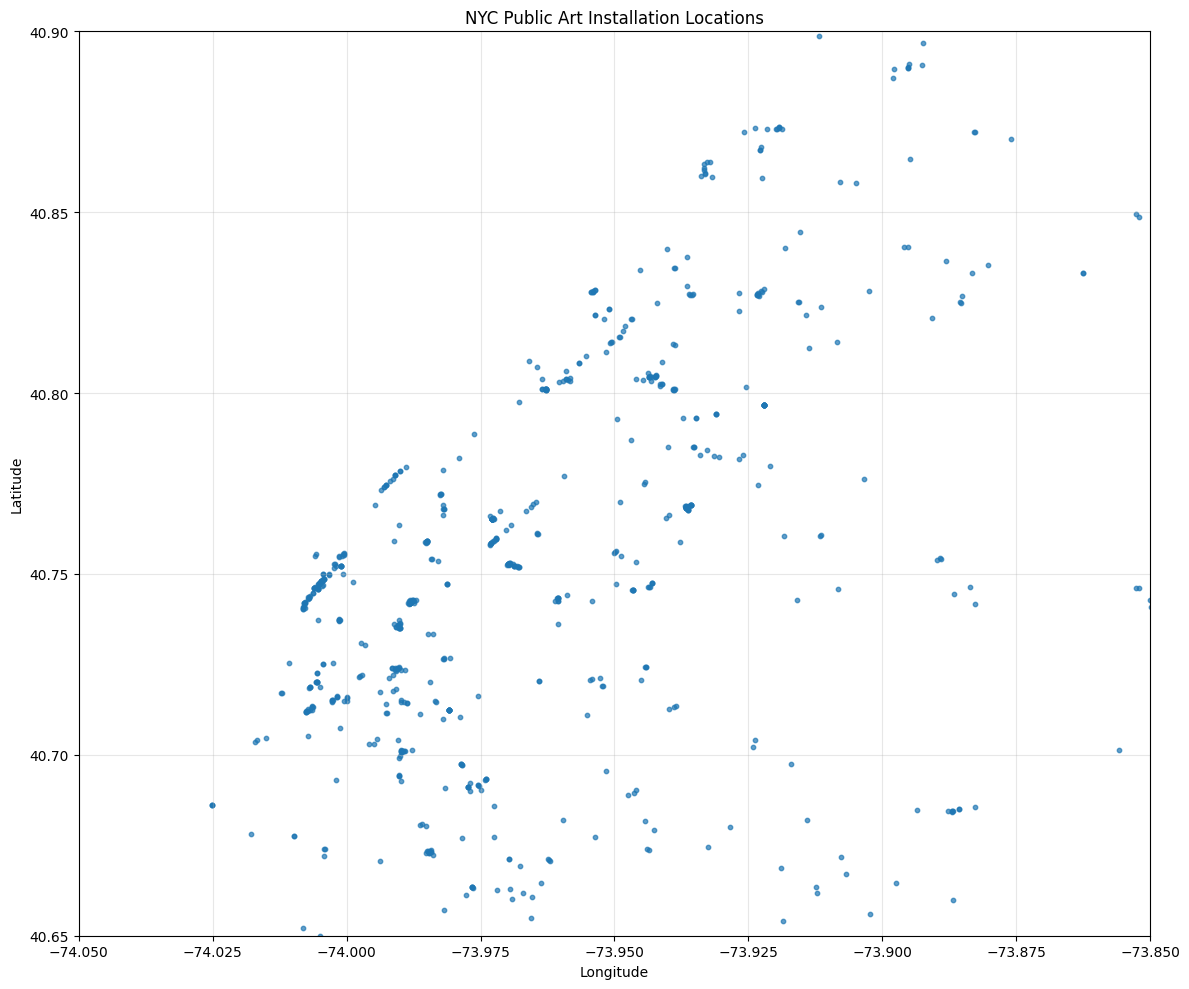

In [24]:
# Process the NYC Public Art data
def preprocess_art_data(df):
    # Check for missing coordinates
    print("Checking coordinates...")

    # Convert 'None' strings to actual None values if needed
    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lng'] = pd.to_numeric(df['lng'], errors='coerce')

    # Count missing coordinates
    missing_coords = df[['lat', 'lng']].isna().any(axis=1)
    print(f"Number of art installations with missing coordinates: {missing_coords.sum()}")
    print(f"Percentage of data with missing coordinates: {missing_coords.mean() * 100:.1f}%")

    # Remove records with missing coordinates
    df_clean = df[~missing_coords].copy()
    print(f"Data shape after removing missing coordinates: {df_clean.shape}")

    # Extract features for clustering
    X = df_clean[['lng', 'lat']].values

    # Display borough distribution
    if 'borough' in df_clean.columns:
        borough_counts = df_clean['borough'].value_counts()
        print("\nBorough distribution:")
        for borough, count in borough_counts.items():
            print(f"  {borough}: {count} installations ({count/len(df_clean)*100:.1f}%)")

    return df_clean, X

# Preprocess the art data
df_art_clean, X_art = preprocess_art_data(df_art)

# Map borough codes to names for better interpretability
borough_map = {
    'M': 'Manhattan',
    'B': 'Brooklyn',
    'Q': 'Queens',
    'X': 'Bronx',
    'R': 'Staten Island',
    'c': 'Citywide'
}

df_art_clean['borough_name'] = df_art_clean['borough'].map(borough_map)

# Visualize the art installation locations
plt.figure(figsize=(12, 10))
plt.scatter(X_art[:, 0], X_art[:, 1], s=10, alpha=0.7)
plt.title('NYC Public Art Installation Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# Set axis limits for NYC area
plt.xlim(-74.05, -73.85)
plt.ylim(40.65, 40.9)

plt.tight_layout()
plt.show()

Evaluating with k=2...
  Inertia: 26266.54
  Silhouette Score: 0.9962
Evaluating with k=3...
  Inertia: 6.15
  Silhouette Score: 0.9992
Evaluating with k=4...
  Inertia: 3.75
  Silhouette Score: 0.4301
Evaluating with k=5...
  Inertia: 2.57
  Silhouette Score: 0.4703
Evaluating with k=6...
  Inertia: 2.05
  Silhouette Score: 0.3930
Evaluating with k=7...
  Inertia: 1.46
  Silhouette Score: 0.4567
Evaluating with k=8...
  Inertia: 1.23
  Silhouette Score: 0.4052
Evaluating with k=9...
  Inertia: 1.01
  Silhouette Score: 0.4271
Evaluating with k=10...
  Inertia: 0.93
  Silhouette Score: 0.3944


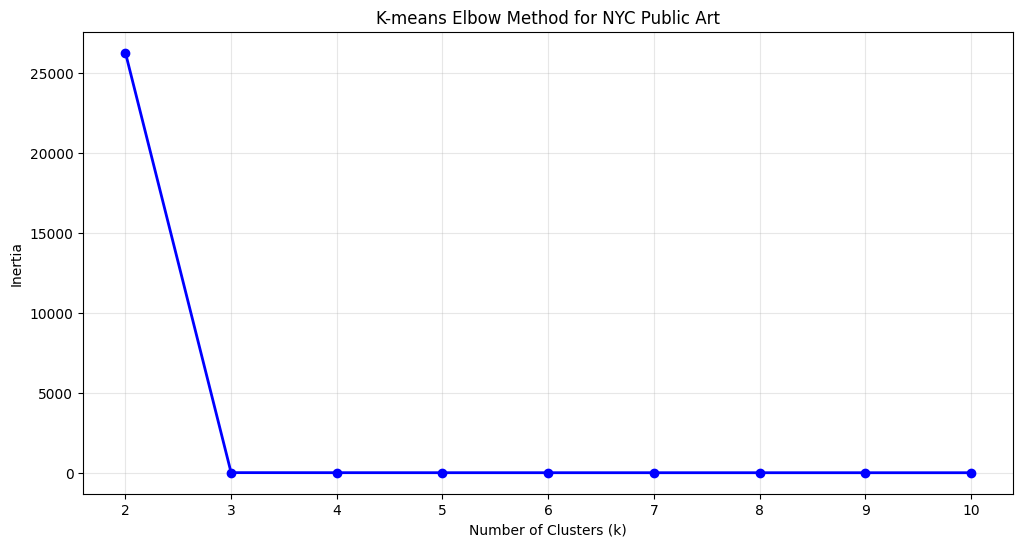

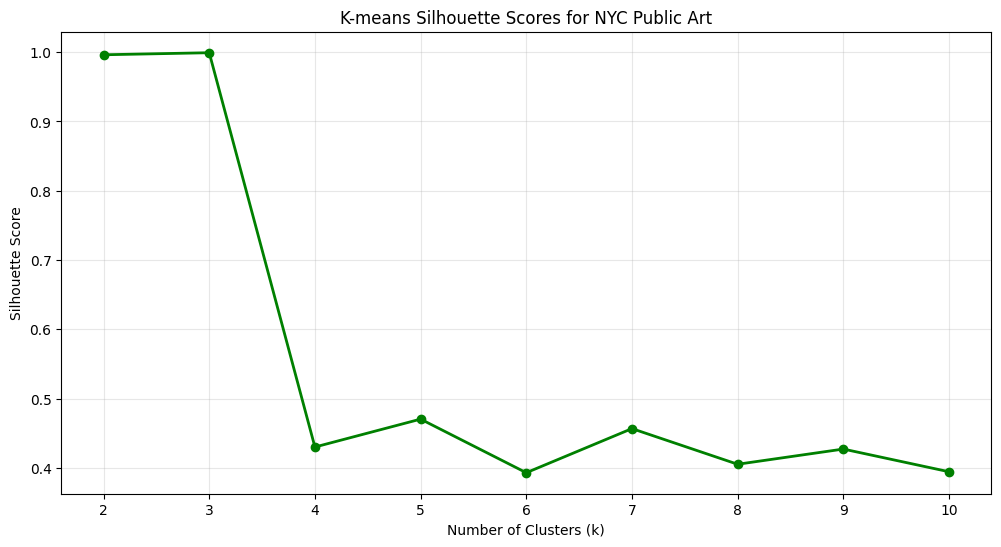

Optimal number of clusters based on silhouette score: 3


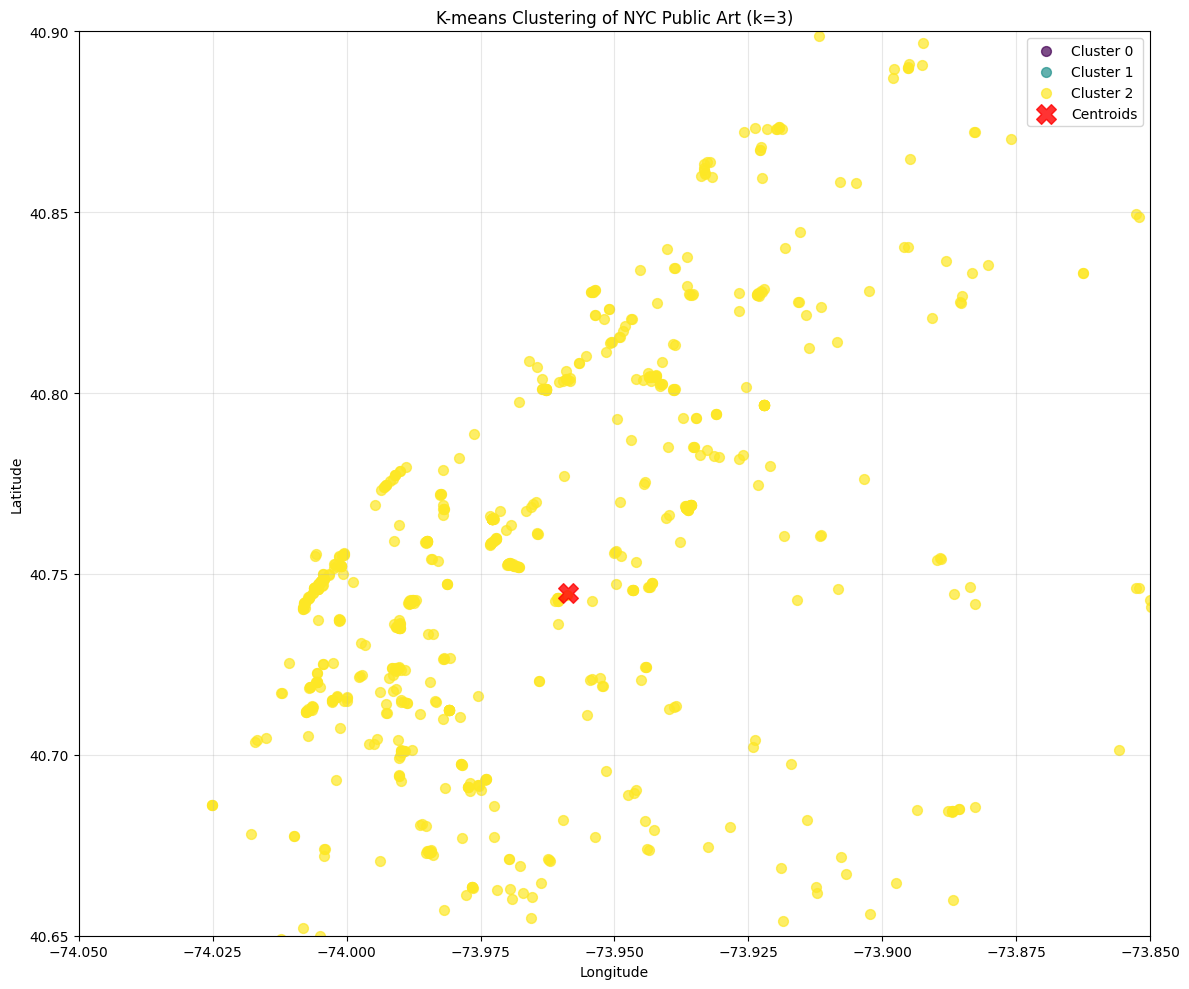

In [25]:
# Apply k-means to the art data
# First, let's find the optimal number of clusters
def evaluate_kmeans_for_art(X, max_clusters=10):
    inertias = []
    silhouette_scores = []

    # Evaluate with k from 2 to max_clusters
    for k in range(2, max_clusters + 1):
        print(f"Evaluating with k={k}...")

        # Use my custom implementation
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(X)

        # Store inertia
        inertias.append(model.inertia_)

        # Calculate silhouette score
        silhouette = silhouette_score(X, model.labels_)
        silhouette_scores.append(silhouette)
        print(f"  Inertia: {model.inertia_:.2f}")
        print(f"  Silhouette Score: {silhouette:.4f}")

    # Plot the elbow method
    plt.figure(figsize=(12, 6))
    plt.plot(range(2, max_clusters + 1), inertias, 'o-', color='blue', linewidth=2)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('K-means Elbow Method for NYC Public Art')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Plot silhouette scores
    plt.figure(figsize=(12, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, 'o-', color='green', linewidth=2)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('K-means Silhouette Scores for NYC Public Art')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Find optimal k based on silhouette score
    optimal_k = range(2, max_clusters + 1)[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

    return inertias, silhouette_scores, optimal_k

# Evaluate optimal k for art data
inertias_art, silhouette_scores_art, optimal_k_art = evaluate_kmeans_for_art(X_art, max_clusters=10)

# Apply k-means with the optimal number of clusters
kmeans_model_art = KMeans(n_clusters=optimal_k_art, random_state=42)
kmeans_model_art.fit(X_art)

# Visualize the clustering results
plt.figure(figsize=(12, 10))

# Create a colormap for clusters
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k_art))

# Plot each cluster with a different color
for i, color in zip(range(optimal_k_art), colors):
    cluster_points = X_art[kmeans_model_art.labels_ == i]
    plt.scatter(
        cluster_points[:, 0], cluster_points[:, 1],
        s=50, c=[color], label=f'Cluster {i}',
        alpha=0.7
    )

# Plot centroids
plt.scatter(
    kmeans_model_art.centroids[:, 0], kmeans_model_art.centroids[:, 1],
    s=200, c='red', marker='X', label='Centroids',
    alpha=0.8
)

plt.title(f'K-means Clustering of NYC Public Art (k={optimal_k_art})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)

# Set axis limits for NYC area
plt.xlim(-74.05, -73.85)
plt.ylim(40.65, 40.9)

plt.tight_layout()
plt.show()


DBSCAN with eps=0.005, min_samples=5
DBSCAN found 37 clusters and 238 noise points
Percentage of noise points: 27.0%
Silhouette Score (excluding noise): 0.7269


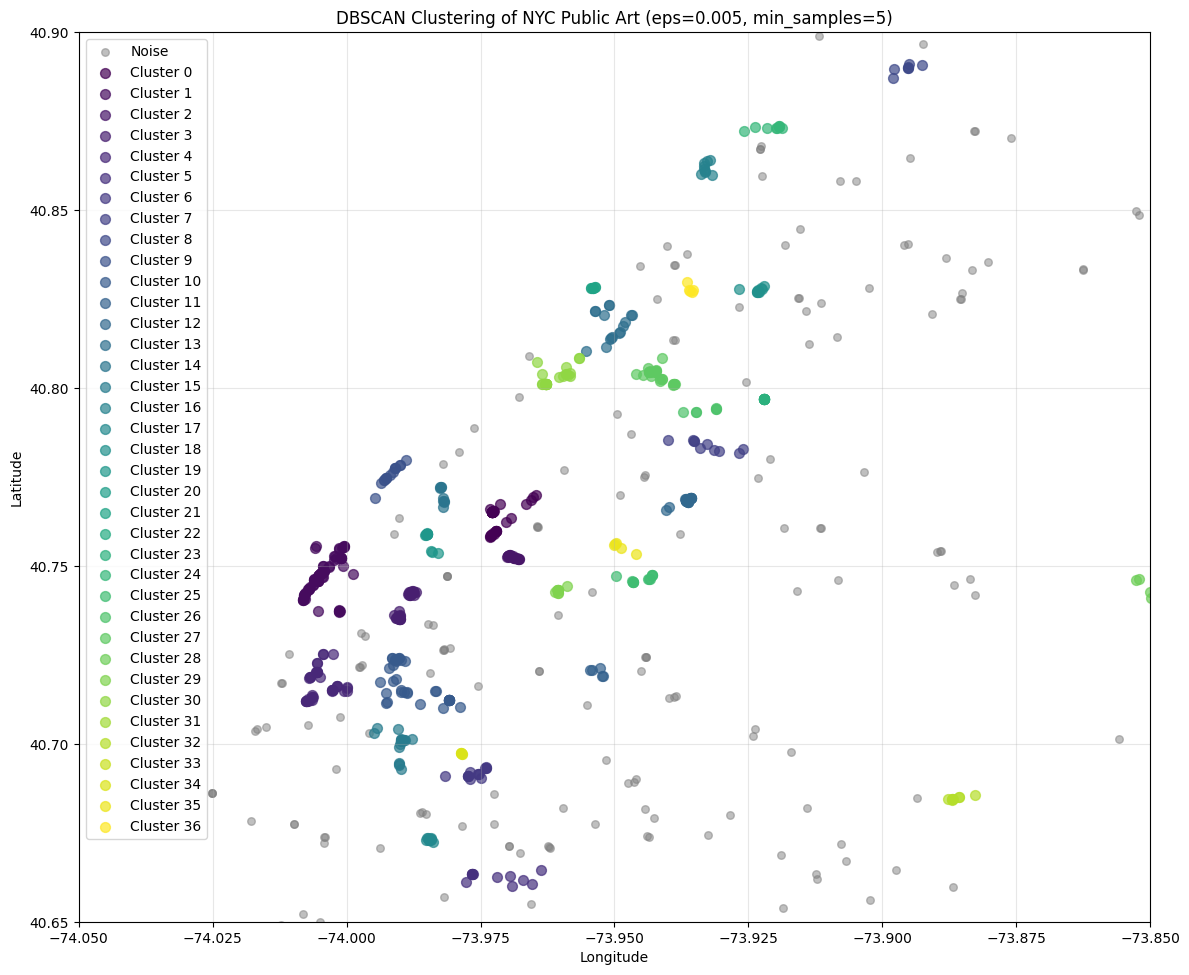


DBSCAN with eps=0.01, min_samples=5
DBSCAN found 18 clusters and 90 noise points
Percentage of noise points: 10.2%
Silhouette Score (excluding noise): 0.2988


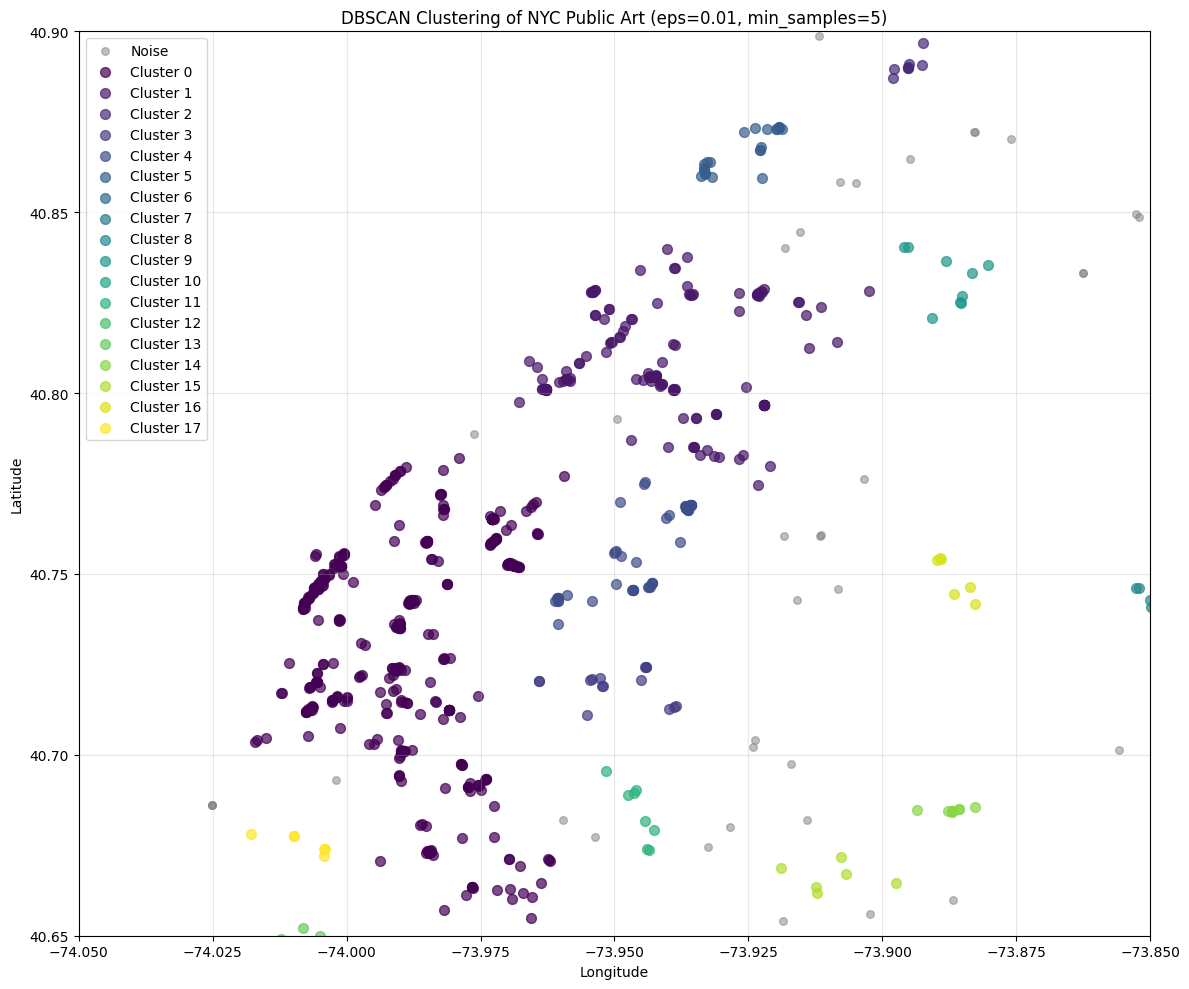


DBSCAN with eps=0.02, min_samples=5
DBSCAN found 9 clusters and 26 noise points
Percentage of noise points: 3.0%
Silhouette Score (excluding noise): 0.1189


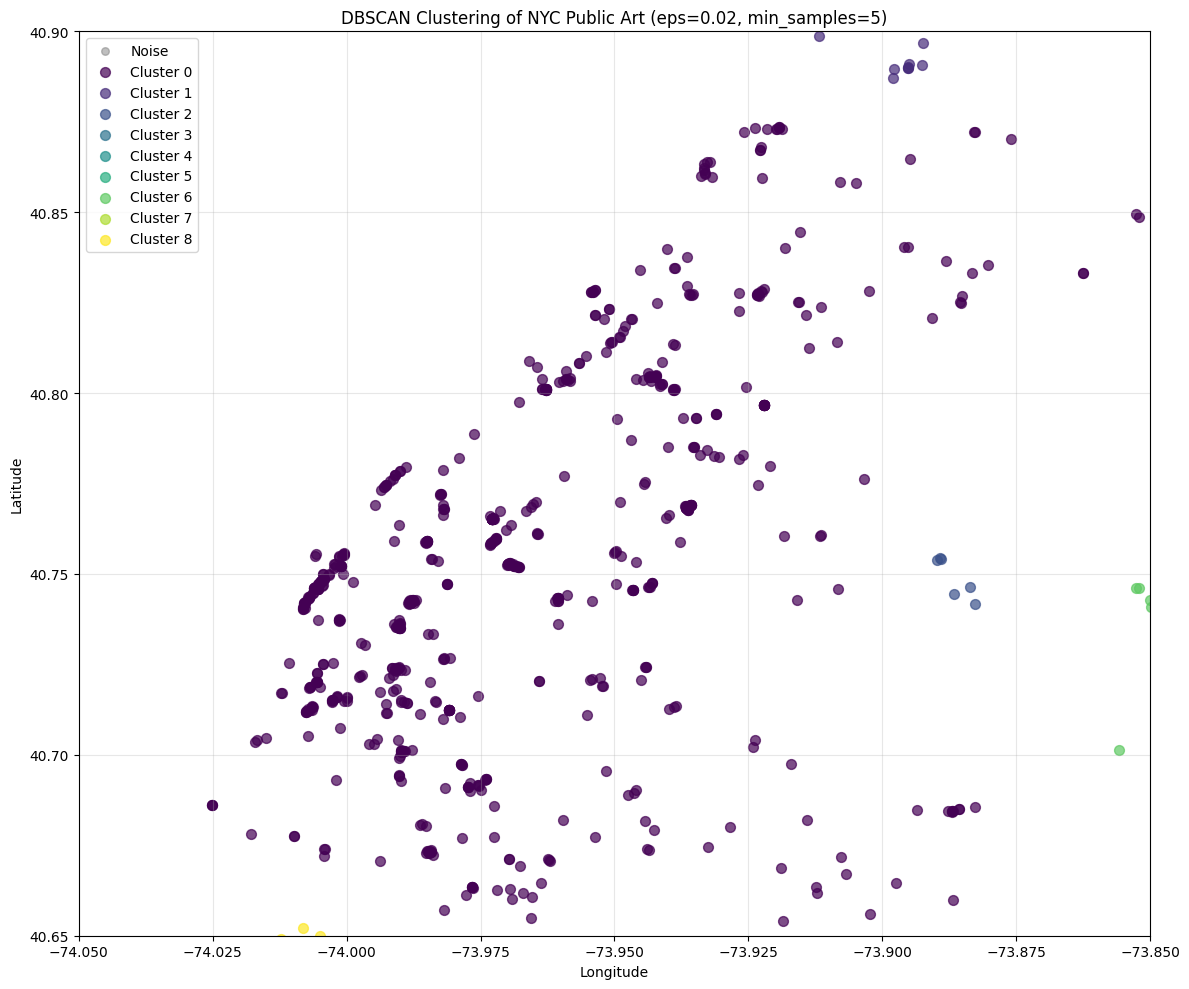


Best DBSCAN configuration: eps=0.005 with silhouette score 0.7269


In [26]:
# Apply DBSCAN to the art data
def apply_dbscan_to_art(X, eps_values=[0.005, 0.01, 0.02], min_samples=5):
    best_silhouette = -1
    best_eps = None
    best_labels = None

    for eps in eps_values:
        print(f"\nDBSCAN with eps={eps}, min_samples={min_samples}")

        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)

        # Count the number of clusters (excluding noise points labeled as -1)
        n_clusters = len(np.unique(labels[labels >= 0]))
        n_noise = np.sum(labels == -1)

        print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points")
        print(f"Percentage of noise points: {n_noise / len(X) * 100:.1f}%")

        # Calculate silhouette score if there are at least 2 clusters and no cluster has only 1 point
        silhouette = None
        if n_clusters >= 2 and np.min(np.bincount(labels[labels >= 0])) > 1:
            # Filter out noise points for silhouette calculation
            X_clustered = X[labels >= 0]
            labels_clustered = labels[labels >= 0]

            silhouette = silhouette_score(X_clustered, labels_clustered)
            print(f"Silhouette Score (excluding noise): {silhouette:.4f}")

            # Keep track of the best configuration
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_eps = eps
                best_labels = labels

        # Visualize DBSCAN results
        plt.figure(figsize=(12, 10))

        # Plot noise points in grey
        noise_points = X[labels == -1]
        if len(noise_points) > 0:
            plt.scatter(
                noise_points[:, 0], noise_points[:, 1],
                s=30, c='gray', label='Noise',
                alpha=0.5
            )

        # Create a colormap for clusters
        colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

        # Plot each cluster with a different color
        for i, color in zip(range(n_clusters), colors):
            cluster_index = i  # DBSCAN labels start from 0 (excluding noise which is -1)
            cluster_points = X[labels == cluster_index]
            plt.scatter(
                cluster_points[:, 0], cluster_points[:, 1],
                s=50, c=[color], label=f'Cluster {cluster_index}',
                alpha=0.7
            )

        plt.title(f'DBSCAN Clustering of NYC Public Art (eps={eps}, min_samples={min_samples})')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Set axis limits for NYC area
        plt.xlim(-74.05, -73.85)
        plt.ylim(40.65, 40.9)

        plt.tight_layout()
        plt.show()

    print(f"\nBest DBSCAN configuration: eps={best_eps} with silhouette score {best_silhouette:.4f}")
    return best_labels, best_eps, best_silhouette

# Apply DBSCAN to art data
dbscan_labels_art, best_eps_art, best_silhouette_art = apply_dbscan_to_art(X_art)

In [27]:
# Analyze the clusters
def analyze_art_clusters(X, labels, df, feature_name='cluster'):
    # Add cluster labels to the dataframe
    df_with_clusters = df.copy()
    df_with_clusters[feature_name] = labels

    # Count the number of unique clusters
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels >= 0])  # Exclude noise points labeled as -1

    print(f"\nAnalysis of {n_clusters} clusters:")

    for i in unique_labels:
        cluster_data = df_with_clusters[df_with_clusters[feature_name] == i]

        if i == -1:
            print(f"\nNoise points:")
        else:
            print(f"\nCluster {i}:")

        print(f"  Number of installations: {len(cluster_data)}")

        # Calculate center coordinates
        print(f"  Center: ({cluster_data['lng'].mean():.6f}, {cluster_data['lat'].mean():.6f})")

        # Borough distribution
        if 'borough' in df.columns:
            borough_counts = cluster_data['borough'].value_counts()
            if not borough_counts.empty:
                most_common_borough = borough_counts.idxmax()
                borough_percentage = (borough_counts.max() / len(cluster_data)) * 100

                print(f"  Most common borough: {most_common_borough} ({borough_percentage:.1f}% of cluster)")
                print("  Borough distribution:")
                for borough, count in borough_counts.items():
                    # Map borough code to name if available
                    borough_name = borough_map.get(borough, borough)
                    print(f"    {borough_name}: {count} installations ({count/len(cluster_data)*100:.1f}%)")

        # List some example installations
        print("  Example installations:")
        for _, row in cluster_data.head(3).iterrows():
            print(f"    - {row['name']} by {row['artist']}")

# Analyze k-means clusters for art
print("\nAnalysis of K-means Clusters for NYC Public Art:")
analyze_art_clusters(X_art, kmeans_model_art.labels_, df_art_clean, feature_name='kmeans_cluster')

# Analyze DBSCAN clusters for art
print("\nAnalysis of DBSCAN Clusters for NYC Public Art:")
analyze_art_clusters(X_art, dbscan_labels_art, df_art_clean, feature_name='dbscan_cluster')

# Compare k-means and DBSCAN results
print("\nComparison of K-means and DBSCAN for NYC Public Art:")
print(f"K-means optimal clusters: {optimal_k_art}")
print(f"K-means silhouette score: {silhouette_scores_art[optimal_k_art-2]:.4f}")
print(f"DBSCAN optimal eps: {best_eps_art}")
print(f"DBSCAN silhouette score: {best_silhouette_art:.4f}")


Analysis of K-means Clusters for NYC Public Art:

Analysis of 3 clusters:

Cluster 0:
  Number of installations: 3
  Center: (73.986337, 40.760052)
  Most common borough: M (100.0% of cluster)
  Borough distribution:
    Manhattan: 3 installations (100.0%)
  Example installations:
    - East Harlem At Play by Giannina Gutierrez, Ralph Serrano, Jeremy Vega
    - Curtain Call by Karon Davis
    - On Growth by Kapwani Kiwanga

Cluster 1:
  Number of installations: 2
  Center: (-73.973288, -73.973288)
  Most common borough: M (100.0% of cluster)
  Borough distribution:
    Manhattan: 2 installations (100.0%)
  Example installations:
    - To Each Their Own by Various Artists
    - Thomas J Price: Witness by Thomas J Price

Cluster 2:
  Number of installations: 875
  Center: (-73.958669, 40.744669)
  Most common borough: M (55.2% of cluster)
  Borough distribution:
    Manhattan: 483 installations (55.2%)
    Queens: 154 installations (17.6%)
    Brooklyn: 150 installations (17.1%)
    Bro

## Part 4: Balanced Clusters Extension (Optional for Exemplary)



In [31]:
# Balanced Clusters Extension

class BalancedKMeans(KMeans):

    def __init__(self, n_clusters=3, max_iters=100, random_state=None, balance_factor=0.5):
        super().__init__(n_clusters=n_clusters, max_iters=max_iters, random_state=random_state)
        self.balance_factor = balance_factor

    def fit(self, X):
        # Set random seed if provided
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Get dimensions of the data
        n_samples, n_features = X.shape

        # The ideal balanced cluster size
        target_size = n_samples // self.n_clusters

        # Initialize centroids randomly from data points
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices, :]

        # Initialize previous centroids to None for first iteration
        prev_centroids = None

        # Iterate until convergence or max_iters
        for _ in range(self.max_iters):
            # Calculate distances to centroids for all points
            distances = self._calculate_distances(X)

            # Apply balanced assignment
            self._balanced_assignment(distances, target_size)

            # Store the previous centroids for convergence check
            prev_centroids = self.centroids.copy()

            # Update centroids based on the mean of points in each cluster
            self._update_centroids(X)

            # Check for convergence
            if np.all(prev_centroids == self.centroids):
                break

        # Calculate inertia (sum of squared distances to the nearest centroid)
        self.inertia_ = self._calculate_inertia(X)

        return self

    def _balanced_assignment(self, distances, target_size):
        n_samples = distances.shape[0]

        # Sort points by their preference for each cluster
        # For each point, get the indices of clusters sorted by distance (ascending)
        point_preferences = np.argsort(distances, axis=1)

        # Initialize cluster assignments and sizes
        self.labels_ = np.full(n_samples, -1)  # -1 means unassigned
        cluster_sizes = np.zeros(self.n_clusters, dtype=int)

        # Calculate maximum allowed cluster size with balance factor
        # As balance_factor approaches 1, max_size approaches target_size
        # As balance_factor approaches 0, max_size approaches n_samples
        max_size = int(target_size + (n_samples - target_size * self.n_clusters) * (1 - self.balance_factor))

        # First pass: assign points to their first preference
        # as long as the cluster is not over-filled
        for i in range(n_samples):
            preferred_cluster = point_preferences[i, 0]
            if cluster_sizes[preferred_cluster] < max_size:
                self.labels_[i] = preferred_cluster
                cluster_sizes[preferred_cluster] += 1

        # Second pass: assign remaining points
        unassigned = np.where(self.labels_ == -1)[0]
        for i in unassigned:
            # Try each preference in order
            for cluster in point_preferences[i]:
                if cluster_sizes[cluster] < max_size:
                    self.labels_[i] = cluster
                    cluster_sizes[cluster] += 1
                    break

            # If still unassigned, force into smallest cluster
            if self.labels_[i] == -1:
                smallest_cluster = np.argmin(cluster_sizes)
                self.labels_[i] = smallest_cluster
                cluster_sizes[smallest_cluster] += 1


=== NYC Schools Clustering: Standard vs. Balanced K-means ===
Number of clusters (k): 5

Standard K-means:
  Cluster sizes: [  5 337 890  84 873]
  Size variance: 143306.96
  Min/Max size: 5/890 (ratio: 178.00)
  Silhouette score: 0.5155
  Inertia: 6.68

Balanced K-means results:

  Balance factor: 0.3
    Cluster sizes: [439 439 439 439 433]
    Size variance: 5.76 (100.0% reduction)
    Min/Max size: 433/439 (ratio: 1.01)
    Silhouette score: 0.0454
    Inertia: 35238.42 (527490.1% increase)

  Balance factor: 0.5
    Cluster sizes: [439 439 439 439 433]
    Size variance: 5.76 (100.0% reduction)
    Min/Max size: 433/439 (ratio: 1.01)
    Silhouette score: 0.0454
    Inertia: 35238.42 (527490.1% increase)

  Balance factor: 0.7
    Cluster sizes: [438 438 438 438 437]
    Size variance: 0.16 (100.0% reduction)
    Min/Max size: 437/438 (ratio: 1.00)
    Silhouette score: 0.0435
    Inertia: 35242.26 (527547.6% increase)

  Balance factor: 0.9
    Cluster sizes: [438 438 438 438 43

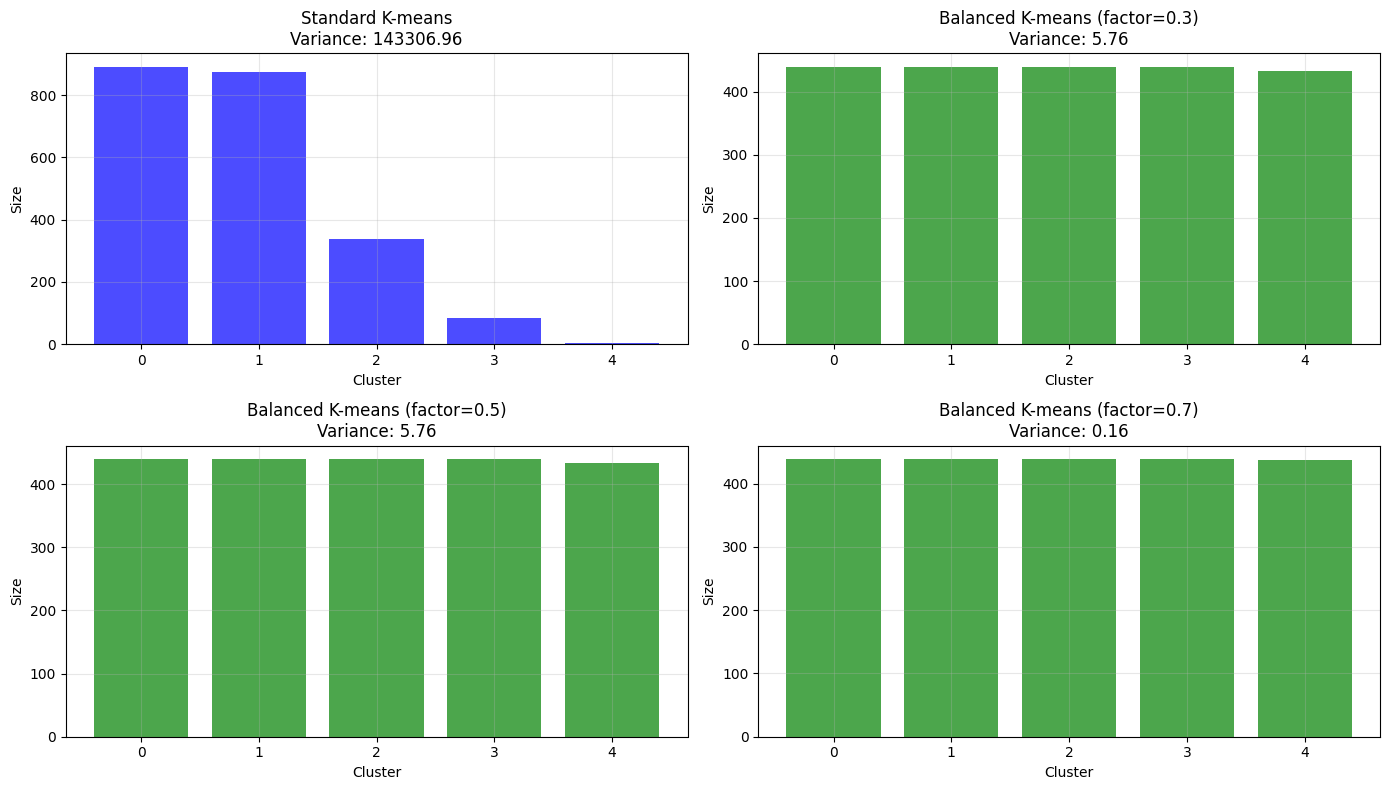

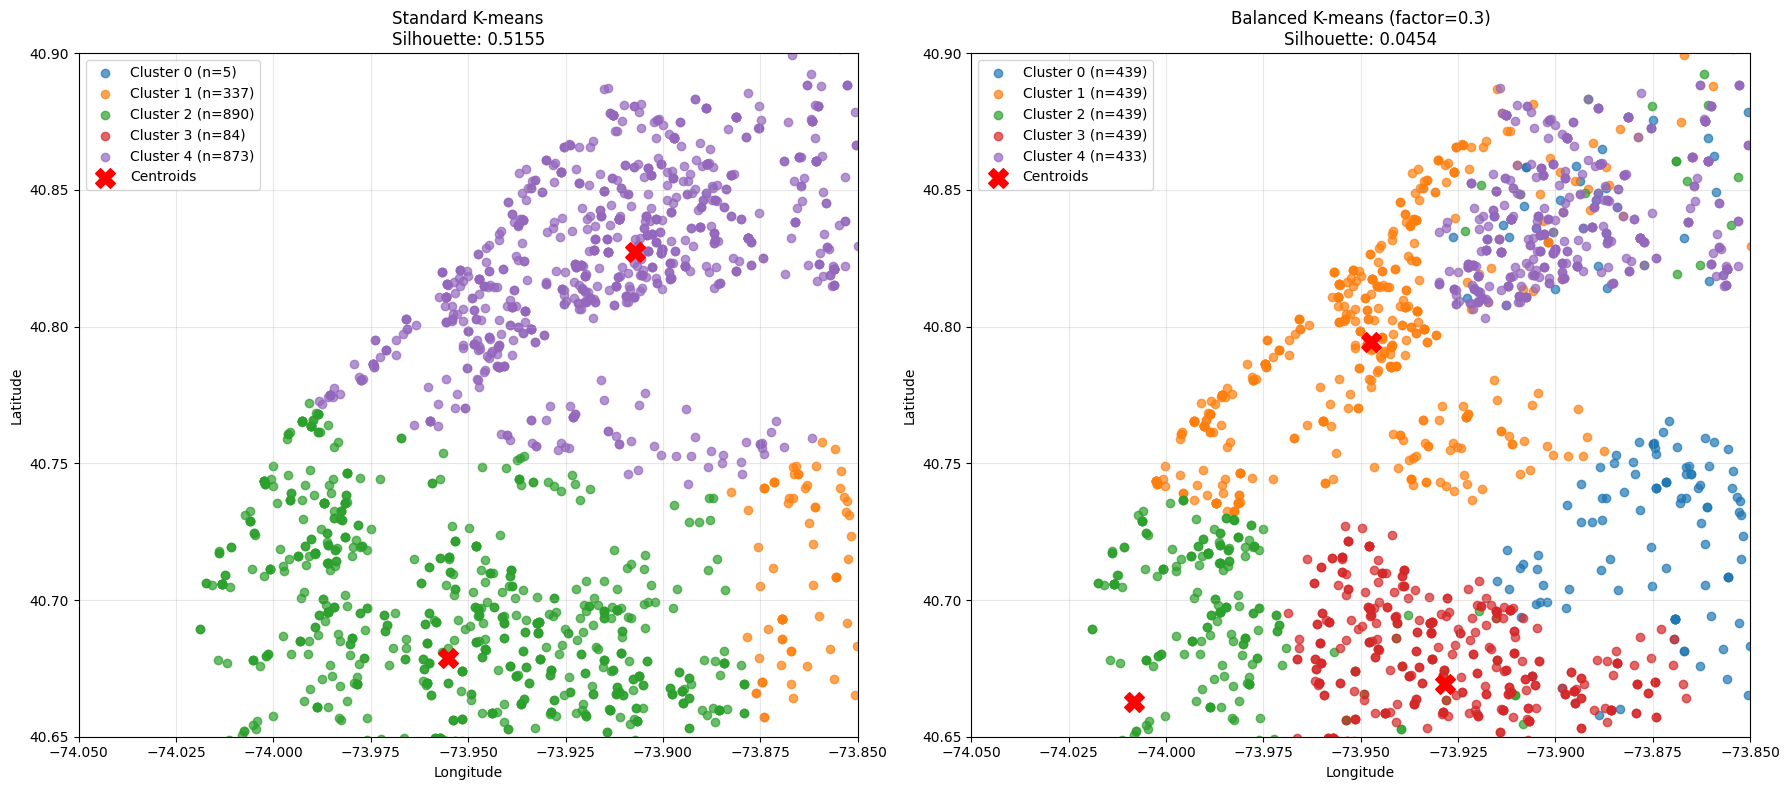


=== NYC Public Art Clustering: Standard vs. Balanced K-means ===
Number of clusters (k): 4

Standard K-means:
  Cluster sizes: [  3   2 316 559]
  Size variance: 54687.50
  Min/Max size: 2/559 (ratio: 279.50)
  Silhouette score: 0.4301
  Inertia: 3.75

Balanced K-means results:

  Balance factor: 0.3
    Cluster sizes: [220 220 220 220]
    Size variance: 0.00 (100.0% reduction)
    Min/Max size: 220/220 (ratio: 1.00)
    Silhouette score: -0.0626
    Inertia: 90869.81 (2424259.6% increase)

  Balance factor: 0.5
    Cluster sizes: [220 220 220 220]
    Size variance: 0.00 (100.0% reduction)
    Min/Max size: 220/220 (ratio: 1.00)
    Silhouette score: -0.0626
    Inertia: 90869.81 (2424259.6% increase)

  Balance factor: 0.7
    Cluster sizes: [220 220 220 220]
    Size variance: 0.00 (100.0% reduction)
    Min/Max size: 220/220 (ratio: 1.00)
    Silhouette score: -0.0626
    Inertia: 90869.81 (2424259.6% increase)

  Balance factor: 0.9
    Cluster sizes: [220 220 220 220]
    Size 

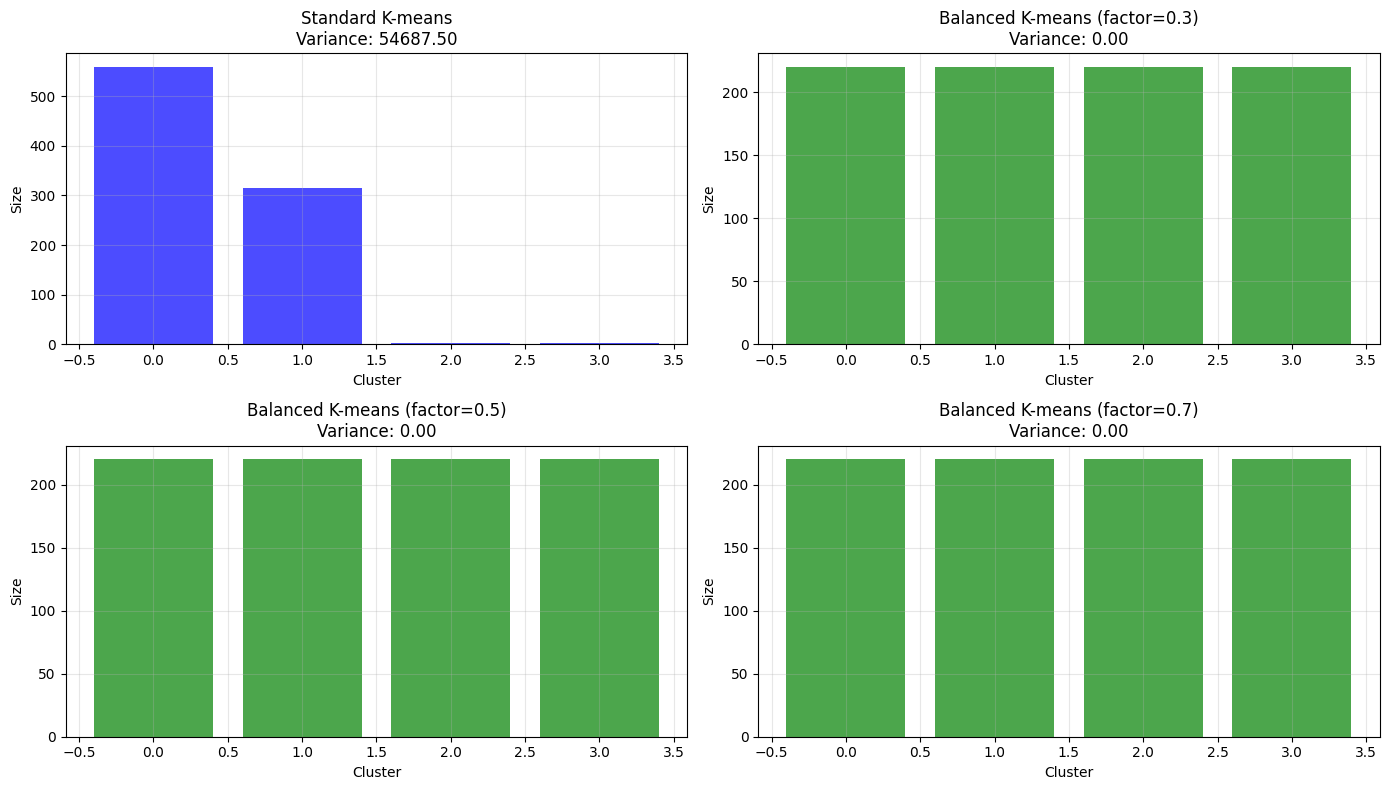

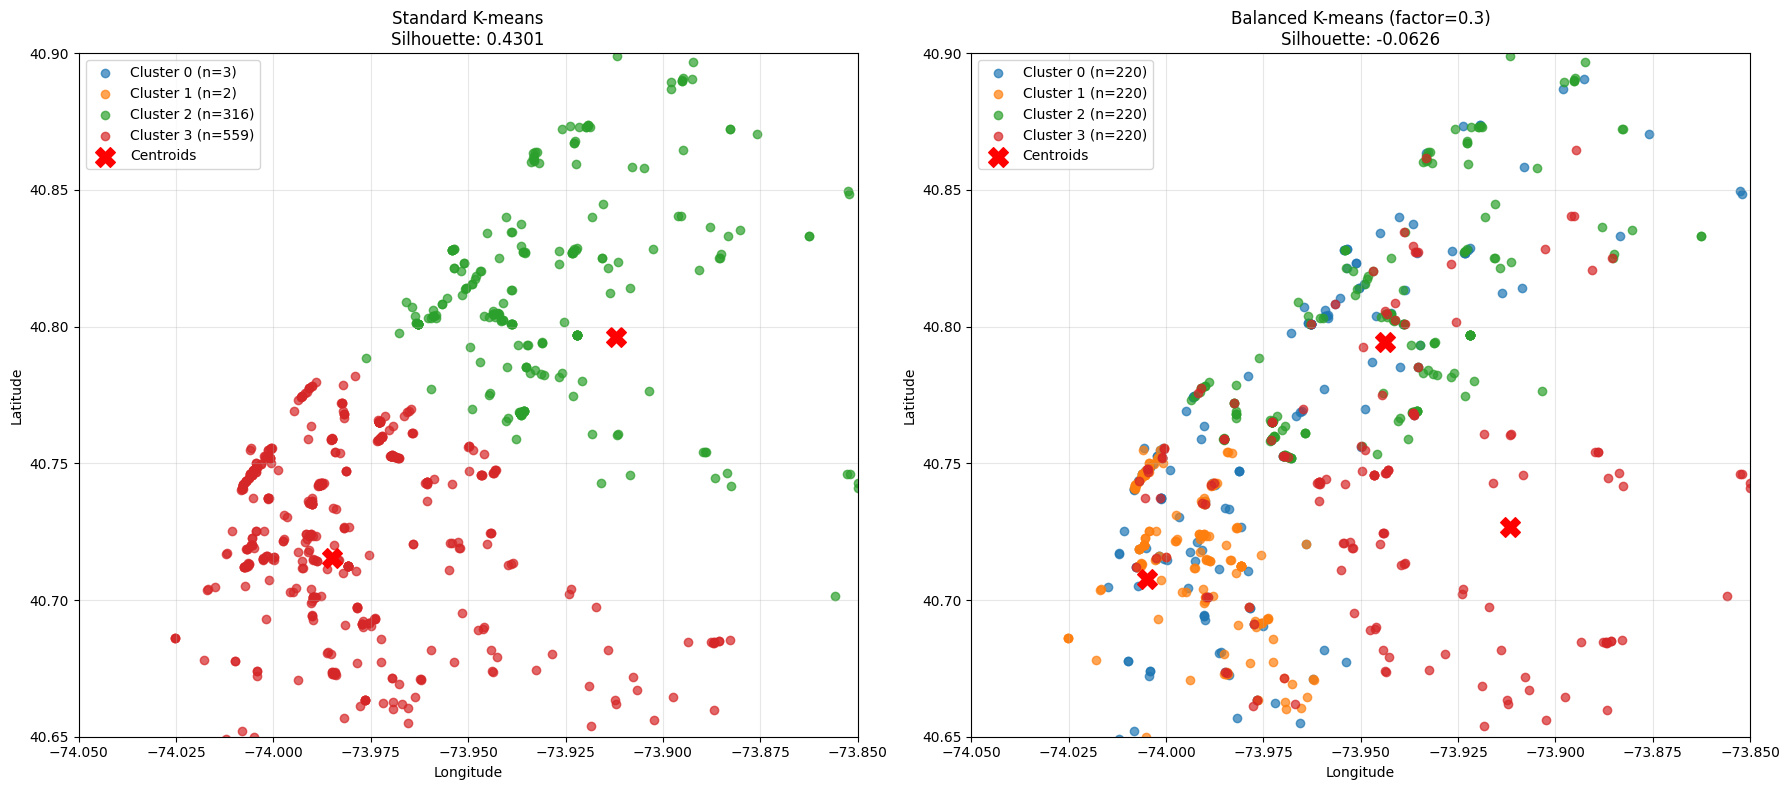

In [32]:
# Test BalancedKMeans on NYC Schools data
def compare_balanced_vs_standard(X, k=5, dataset_name="Dataset"):
    # Apply standard k-means
    standard_kmeans = KMeans(n_clusters=k, random_state=42)
    standard_kmeans.fit(X)

    # Get cluster sizes
    standard_sizes = np.bincount(standard_kmeans.labels_)
    standard_var = np.var(standard_sizes)
    standard_min = np.min(standard_sizes)
    standard_max = np.max(standard_sizes)
    standard_ratio = standard_max / standard_min if standard_min > 0 else float('inf')

    # Calculate silhouette score
    standard_silhouette = silhouette_score(X, standard_kmeans.labels_)

    # Try different balance factors
    balance_factors = [0.3, 0.5, 0.7, 0.9]
    balanced_results = []

    for bf in balance_factors:
        # Apply balanced k-means
        balanced_kmeans = BalancedKMeans(n_clusters=k, random_state=42, balance_factor=bf)
        balanced_kmeans.fit(X)

        # Get cluster sizes
        balanced_sizes = np.bincount(balanced_kmeans.labels_)
        balanced_var = np.var(balanced_sizes)
        balanced_min = np.min(balanced_sizes)
        balanced_max = np.max(balanced_sizes)
        balanced_ratio = balanced_max / balanced_min if balanced_min > 0 else float('inf')

        # Calculate silhouette score
        balanced_silhouette = silhouette_score(X, balanced_kmeans.labels_)

        # Calculate inertia increase (cost of balancing)
        inertia_increase = (balanced_kmeans.inertia_ - standard_kmeans.inertia_) / standard_kmeans.inertia_ * 100

        balanced_results.append({
            'balance_factor': bf,
            'sizes': balanced_sizes,
            'variance': balanced_var,
            'min_size': balanced_min,
            'max_size': balanced_max,
            'size_ratio': balanced_ratio,
            'silhouette': balanced_silhouette,
            'inertia': balanced_kmeans.inertia_,
            'inertia_increase': inertia_increase,
            'model': balanced_kmeans
        })

    # Print results
    print(f"\n=== {dataset_name} Clustering: Standard vs. Balanced K-means ===")
    print(f"Number of clusters (k): {k}")
    print(f"\nStandard K-means:")
    print(f"  Cluster sizes: {standard_sizes}")
    print(f"  Size variance: {standard_var:.2f}")
    print(f"  Min/Max size: {standard_min}/{standard_max} (ratio: {standard_ratio:.2f})")
    print(f"  Silhouette score: {standard_silhouette:.4f}")
    print(f"  Inertia: {standard_kmeans.inertia_:.2f}")

    print("\nBalanced K-means results:")
    for result in balanced_results:
        bf = result['balance_factor']
        print(f"\n  Balance factor: {bf}")
        print(f"    Cluster sizes: {result['sizes']}")
        print(f"    Size variance: {result['variance']:.2f} ({(1 - result['variance']/standard_var) * 100:.1f}% reduction)")
        print(f"    Min/Max size: {result['min_size']}/{result['max_size']} (ratio: {result['size_ratio']:.2f})")
        print(f"    Silhouette score: {result['silhouette']:.4f}")
        print(f"    Inertia: {result['inertia']:.2f} ({result['inertia_increase']:.1f}% increase)")

    # Create visualization comparing cluster size distributions
    plt.figure(figsize=(14, 8))

    # Standard k-means
    plt.subplot(2, 2, 1)
    plt.bar(range(len(standard_sizes)), sorted(standard_sizes, reverse=True), color='blue', alpha=0.7)
    plt.title(f'Standard K-means\nVariance: {standard_var:.2f}')
    plt.xlabel('Cluster')
    plt.ylabel('Size')
    plt.grid(True, alpha=0.3)

    # Balanced k-means with different factors
    for i, result in enumerate(balanced_results):
        if i < 3:  # Only show first 3 results in plot
            plt.subplot(2, 2, i+2)
            plt.bar(range(len(result['sizes'])), sorted(result['sizes'], reverse=True),
                   color='green', alpha=0.7)
            plt.title(f'Balanced K-means (factor={result["balance_factor"]})\nVariance: {result["variance"]:.2f}')
            plt.xlabel('Cluster')
            plt.ylabel('Size')
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Visualize the clustering results for the best balanced k-means
    best_balanced = min(balanced_results, key=lambda x: abs(x['inertia_increase'] - 10))

    # Create scatter plots
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # Standard k-means
    for i in range(k):
        cluster_points = X[standard_kmeans.labels_ == i]
        if len(cluster_points) > 0:
            axs[0].scatter(
                cluster_points[:, 0], cluster_points[:, 1],
                label=f'Cluster {i} (n={len(cluster_points)})',
                alpha=0.7
            )

    axs[0].scatter(
        standard_kmeans.centroids[:, 0], standard_kmeans.centroids[:, 1],
        c='red', marker='X', s=200, label='Centroids'
    )
    axs[0].set_title(f'Standard K-means\nSilhouette: {standard_silhouette:.4f}')
    axs[0].set_xlabel('Longitude')
    axs[0].set_ylabel('Latitude')
    axs[0].grid(True, alpha=0.3)
    axs[0].legend()

    # Set axis limits for NYC area
    axs[0].set_xlim(-74.05, -73.85)
    axs[0].set_ylim(40.65, 40.9)

    # Best balanced k-means
    for i in range(k):
        cluster_points = X[best_balanced['model'].labels_ == i]
        if len(cluster_points) > 0:
            axs[1].scatter(
                cluster_points[:, 0], cluster_points[:, 1],
                label=f'Cluster {i} (n={len(cluster_points)})',
                alpha=0.7
            )

    axs[1].scatter(
        best_balanced['model'].centroids[:, 0], best_balanced['model'].centroids[:, 1],
        c='red', marker='X', s=200, label='Centroids'
    )
    axs[1].set_title(f'Balanced K-means (factor={best_balanced["balance_factor"]})\nSilhouette: {best_balanced["silhouette"]:.4f}')
    axs[1].set_xlabel('Longitude')
    axs[1].set_ylabel('Latitude')
    axs[1].grid(True, alpha=0.3)
    axs[1].legend()

    # Set axis limits for NYC area
    axs[1].set_xlim(-74.05, -73.85)
    axs[1].set_ylim(40.65, 40.9)

    plt.tight_layout()
    plt.show()

    return standard_kmeans, best_balanced['model']

# Test on NYC Schools data
k_schools = 5  # Use the optimal k determined earlier
standard_kmeans_schools, balanced_kmeans_schools = compare_balanced_vs_standard(
    X_schools, k=k_schools, dataset_name="NYC Schools"
)

# Test on NYC Public Art data
k_art = 4  # Use the optimal k determined earlier
standard_kmeans_art, balanced_kmeans_art = compare_balanced_vs_standard(
    X_art, k=k_art, dataset_name="NYC Public Art"
)

In [30]:
# Analysis of real-world applications for balanced clustering
def analyze_balanced_clustering_benefits():
    """
    Generate analysis of balanced clustering benefits and applications.
    """
    print("\n=== BALANCED CLUSTERING: APPLICATIONS AND TRADE-OFFS ===")

    print("\nReal-world applications for balanced clustering:")
    print("  1. School District Planning:")
    print("     - Creating school zones with similar numbers of students")
    print("     - Balancing student populations across multiple schools")
    print("     - Planning bus routes with similar numbers of stops")

    print("\n  2. Public Services and Resource Allocation:")
    print("     - Designing police precincts with balanced workloads")
    print("     - Planning emergency service coverage areas")
    print("     - Allocating city maintenance crews to balanced regions")

    print("\n  3. Business Operations:")
    print("     - Designing balanced sales territories")
    print("     - Assigning customers to service representatives")
    print("     - Creating delivery zones for logistics companies")

    print("\nTrade-offs in balanced clustering:")
    print("  1. Cluster Quality vs. Size Balance:")
    print("     - As balance increases, clusters may become less cohesive")
    print("     - Inertia typically increases, indicating lower clustering quality")
    print("     - Points may be assigned to clusters farther from their natural groups")

    print("\n  2. Performance Metrics:")
    print("     - Traditional metrics like silhouette score may decrease")
    print("     - Need for new metrics that incorporate balance considerations")

    print("\nBalancing Factor Selection:")
    print("  - Low factors (0.1-0.3): Minimal balancing, slight improvement in size distribution")
    print("  - Medium factors (0.4-0.6): Moderate balancing with acceptable quality trade-off")
    print("  - High factors (0.7-0.9): Strong balancing but potential significant quality loss")
    print("  - Optimal selection depends on application priorities")

# Run the analysis
analyze_balanced_clustering_benefits()


=== BALANCED CLUSTERING: APPLICATIONS AND TRADE-OFFS ===

Real-world applications for balanced clustering:
  1. School District Planning:
     - Creating school zones with similar numbers of students
     - Balancing student populations across multiple schools
     - Planning bus routes with similar numbers of stops

  2. Public Services and Resource Allocation:
     - Designing police precincts with balanced workloads
     - Planning emergency service coverage areas
     - Allocating city maintenance crews to balanced regions

  3. Business Operations:
     - Designing balanced sales territories
     - Assigning customers to service representatives
     - Creating delivery zones for logistics companies

Trade-offs in balanced clustering:
  1. Cluster Quality vs. Size Balance:
     - As balance increases, clusters may become less cohesive
     - Inertia typically increases, indicating lower clustering quality
     - Points may be assigned to clusters farther from their natural groups


## Reflection Questions

### NYC Schools Analysis

1.   Why did you choose specific preprocessing steps for each dataset?


2.   What influenced your choice of clustering algorithm for each dataset?


3.   How do your clustering results relate to real-world geographical representations?


4.   What challenges did you encounter and how did you address them?


5.   How would you improve your approach given more time?

### NYC Public Art Analysis

1.   Why did you choose specific preprocessing steps for each dataset?


2.   What influenced your choice of clustering algorithm for each dataset?


3.   How do your clustering results relate to real-world geographical representations?


4.   What challenges did you encounter and how did you address them?


5.   How would you improve your approach given more time?



## NYC School Dataset Analysis:

1) For this dataset, my main focus was to handle the missing coordinate values. I noticed that some schools didn't have lattitudes or longitutudes information which could lead to a lot of headache while clustering. I decided to throw them in the trash rather than try to estimate locations because accuracy is very essential for this kind of clustering spaces. I did not go for standardizing because it might actually mess with the distances between points and because latitude and longitude are already on somewhat similar scales.

2) School are distributed somewhat evenly in NYC so I used K means. K means works really well when clusters are expected to have spherical shapes (going off of the assumption that I think we established in class but if it's not the case then I might be in trouble). After reading the elbow plut and silhouette scores analysis, I decided on 5 clusters which were able to produce a good balance between cohesion and separation of clusters within and between. DBScan was also used to see how a density based approach would differ from a centroied based kmeans approach.

3) I believe we did a pretty darn good job of mapping and relating to the five boroughs of NYC. I mean the boundaries aren't exact but I noticed that the clusters roughly correspond to how NYC is divided into Manhattan, Brooklyn, Queens, Bronx, and Staten Island. This actually makes sense to how I would assume the schools are distributed according to population distribution/density and follow the actual geography of the city. We can also establish some conclusions based on the concentration of schools and population densityin certain areas.

4) I mean besides the usual know your data, visualize your data bla blas a big challenge was deciding on the optimal number of clusters. The elbow method wasn't really clear and I had to balance between silhouette scores and what made sense to me for NYC's geography. Another obstacle I faced was that some schools were very close to each other in denser areas while others were galaxies away in less populated areas. I experimented with different k values and I compared the resulting clusters visually but ended up settling for the k value used in the data above.

5) If I had more time I would've loved to explore features beyond the geographical location coordinates. I would look into school types to create more meaningful clusters. Maybe I can do something to explore the nested structure of school distributions.

## NYC Public Art Analysis

1) For this dataset, preprocessing was more challenging because whoever chose to share this data in JSON format wanted to watch the world burn. I spent time understanding the structure of the data and I tried uploading this data to an LLM to help me understand the sturcure but even AI gave up on me and told me my upload was too large. I made sure I fully understood the structure and ensured the coordinate information was extracted properly, I had to handle missing coordinates but the art dataset had a higher percentage of missing values. I decided to only work with valid coordinates.

2) For this dataset, I also used both Kmeans and DBScan because the art installations have a very different distribution pattern in comparison to schools. Public art in my opibiob tends to be more clustered in cultural areas (not sure if that's even a thing but I hope my point is clear) or like specific streets. DBScan is more suitable due to its ability to find clusters of certain shapes and identify outliers. After performing the analysis I found that Kmeans with 4 clusters and DBScan with good parameters produced great output.

3) I saw interesting patterns in how public art is distributed across NYC. Theres a heavy concentration in what I believe is Manhattan. The DBScan was great at identifying dense art hotspots while also discovering noise. This reflects how the world of art tends to be concentrated in certain areas that are culturally rich rather than having an evenly spread out distribution.

4) THE MAIN CHALLENGE WAS JSON! But with regards to data I saw that the highest concentration of installations created very imbalanced clusters. Smaller areas had dozens of installations while large areas had very few. I addressed this by experimenting with the balanced K-means approach in the exemplary part, which helped create more evenly sized clusters (or at least attempted to).

5)Given more time, I would incorporate the textual information about the installations including artist names, time periods, descriptions etc... Art is all about styling and creativity and that way I would be themeing data.